This notebook implements a comprehensive time series forecasting pipeline for bike usage data with 15-minute intervals, including:

1. Data Loading and Preprocessing
2. Missing Value Imputation  
3. Exploratory Data Analysis
4. Stationarity Testing
5. Model Training (ARIMA, ETS, Random Forest)
6. Model Evaluation and Comparison
7. Future Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## STEP 1: DATA LOADING AND INITIAL EXPLORATION

In [2]:
# Load and examine data
df = pd.read_csv("data/preprocessed/ts_data_15min.csv")

print(f"Dataset columns: {df.columns.tolist()}")
print(f"Dataset shape: {df.shape}")
print(f"Data types:\n{df.dtypes}")

# Convert dateTime to datetime
df["dateTime"] = pd.to_datetime(df["dateTime"])

# Set datetime as index
df.set_index("dateTime", inplace=True)

Dataset columns: ['dateTime', 'bikesInUsage', 'electricalBikesInUsage', 'mechanicalBikesInUsage']
Dataset shape: (22752, 4)
Data types:
dateTime                   object
bikesInUsage              float64
electricalBikesInUsage    float64
mechanicalBikesInUsage    float64
dtype: object


In [3]:
df.head()

,bikesInUsage,electricalBikesInUsage,mechanicalBikesInUsage
dateTime,,,
2018-08-01 00:00:00,NaN,NaN,NaN
2018-08-01 00:15:00,NaN,NaN,NaN
2018-08-01 00:30:00,NaN,NaN,NaN
2018-08-01 00:45:00,NaN,NaN,NaN
2018-08-01 01:00:00,NaN,NaN,NaN


## STEP 2: INITIAL DATA VISUALIZATION

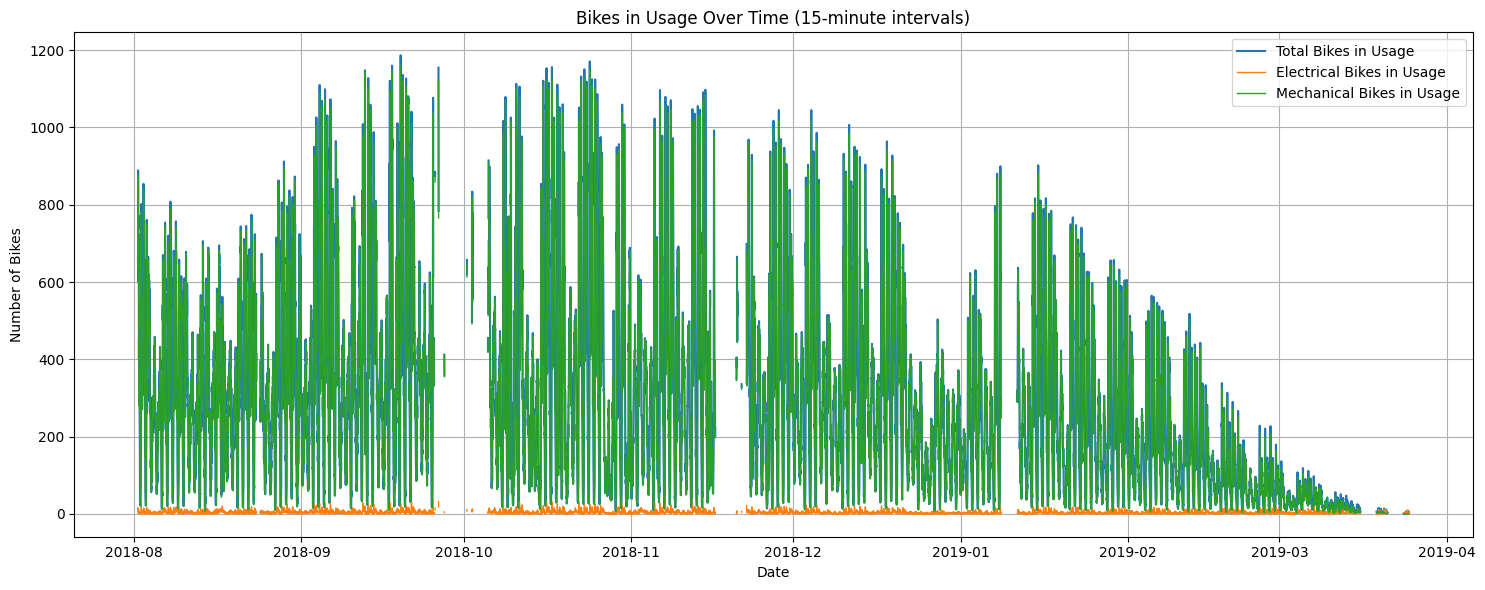

In [4]:
# Plot each time series with NaNs naturally omitted
plt.figure(figsize=(15, 6))
plt.plot(df.index, df["bikesInUsage"], label="Total Bikes in Usage", linewidth=1.5)
plt.plot(df.index, df["electricalBikesInUsage"], label="Electrical Bikes in Usage", linewidth=1)
plt.plot(df.index, df["mechanicalBikesInUsage"], label="Mechanical Bikes in Usage", linewidth=1)

plt.title("Bikes in Usage Over Time (15-minute intervals)")
plt.xlabel("Date")
plt.ylabel("Number of Bikes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## STEP 3: DATA FILTERING AND TRAIN-TEST SPLIT

In [5]:
# Filter data to specific period for analysis
cutoff = "2019-02-01"
df = df.loc[:cutoff]
df

# Compute cutoff date based on 80% of the time span
cutoff_idx = int(len(df) * 0.8)
cutoff_date = df.index[cutoff_idx]

# We split the data chronologically
df_train = df.loc[:cutoff_date].copy()
df_test = df.loc[cutoff_date:].copy()
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print("NA's in train: ", df_train.isna().sum().sum())
print("NA's in test: ", df_test.isna().sum().sum())


Training set shape: (14209, 3)
Test set shape: (3552, 3)
NA's in train:  4806
NA's in test:  882


## STEP 4: MISSING VALUE IMPUTATION

In [6]:
# Create time-group profiles for imputation
df_train["hour"] = df_train.index.hour
df_train["minute"] = df_train.index.minute
df_train["dayofweek"] = df_train.index.dayofweek
df_train["time_group"] = (
    df_train["dayofweek"].astype(str)
    + "-"
    + df_train["hour"].astype(str).str.zfill(2)
    + ":"
    + df_train["minute"].astype(str).str.zfill(2)
)


In [7]:
# Build both profiles from TRAINING SET
electrical_profile = df_train.groupby("time_group")["electricalBikesInUsage"].mean()
electrical_profile

time_group
0-00:00    1.648947
0-00:15    2.035263
0-00:30    1.913158
0-00:45    2.122632
0-01:00    2.140526
             ...   
6-22:45    2.982105
6-23:00    2.526316
6-23:15    3.105263
6-23:30    1.911579
6-23:45    1.912105
Name: electricalBikesInUsage, Length: 672, dtype: float64

In [8]:
mechanical_profile = df_train.groupby("time_group")["mechanicalBikesInUsage"].mean()
mechanical_profile

time_group
0-00:00    159.543684
0-00:15    172.228421
0-00:30    151.351053
0-00:45    129.543684
0-01:00    116.008421
              ...    
6-22:45    188.351579
6-23:00    178.641053
6-23:15    200.368947
6-23:30    184.947368
6-23:45    167.473684
Name: mechanicalBikesInUsage, Length: 672, dtype: float64

In [9]:
# We use these profiles to fill in missing values in df_train
df_train["electricalBikesInUsage_imputed"] = df_train.apply(
    lambda row: electrical_profile[row["time_group"]] 
    if pd.isna(row["electricalBikesInUsage"]) else row["electricalBikesInUsage"], axis=1)

df_train["mechanicalBikesInUsage_imputed"] = df_train.apply(
    lambda row: mechanical_profile[row["time_group"]] 
    if pd.isna(row["mechanicalBikesInUsage"]) else row["mechanicalBikesInUsage"], axis=1)

df_train["bikesInUsage_imputed"] = (
    df_train["electricalBikesInUsage_imputed"] + df_train["mechanicalBikesInUsage_imputed"]
)


In [10]:
# Repeat for df_test
df_test["hour"] = df_test.index.hour
df_test["minute"] = df_test.index.minute
df_test["dayofweek"] = df_test.index.dayofweek
df_test["time_group"] = (
    df_test["dayofweek"].astype(str)
    + "-"
    + df_test["hour"].astype(str).str.zfill(2)
    + ":"
    + df_test["minute"].astype(str).str.zfill(2)
)

In [11]:
df_test["electricalBikesInUsage_imputed"] = df_test.apply(
    lambda row: electrical_profile.get(row["time_group"], np.nan)
    if pd.isna(row["electricalBikesInUsage"]) else row["electricalBikesInUsage"], axis=1)

df_test["mechanicalBikesInUsage_imputed"] = df_test.apply(
    lambda row: mechanical_profile.get(row["time_group"], np.nan)
    if pd.isna(row["mechanicalBikesInUsage"]) else row["mechanicalBikesInUsage"], axis=1)

df_test["bikesInUsage_imputed"] = (
    df_test["electricalBikesInUsage_imputed"] + df_test["mechanicalBikesInUsage_imputed"]
)


## STEP 5: EXPLORATORY DATA ANALYSIS (EDA)

In [12]:
# Plot original vs. imputed bike usage over a specified date range
def plot_original_vs_imputed(df, start_date, end_date, title_prefix="Zoomed View"):
    """
    Plot original vs. imputed bike usage over a specified date range.

    Parameters:
    - df: DataFrame containing 'bikesInUsage' and 'bikesInUsage_imputed' columns
    - start_date: string (e.g., "2019-01-01")
    - end_date: string (e.g., "2019-01-07")
    - title_prefix: optional string to add context to plot title
    """
    df_zoom = df.loc[start_date:end_date]

    fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

    # Plot 1: Original data (with NaNs)
    axes[0].plot(df_zoom.index, df_zoom["bikesInUsage"], label="Original", color="steelblue")
    axes[0].set_title("Original Data (with NaNs)")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Number of Bikes")
    axes[0].grid(True)
    axes[0].legend()

    # Plot 2: Imputed data
    axes[1].plot(df_zoom.index, df_zoom["bikesInUsage_imputed"], label="Imputed", color="orange")
    axes[1].scatter(
        df_zoom.index[df_zoom["bikesInUsage"].isna()],
        df_zoom["bikesInUsage_imputed"][df_zoom["bikesInUsage"].isna()],
        color="red", s=15, label="Imputed Points"
    )
    axes[1].set_title("Imputed Data")
    axes[1].set_xlabel("Date")
    axes[1].grid(True)
    axes[1].legend()

    # Super title
    fig.suptitle(f"{title_prefix}: {start_date} to {end_date}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [13]:
# Some periods to visualize the imputation
periods = [("2018-07-30", "2018-08-05"),
 ("2018-08-20", "2018-08-26"),
 ("2018-10-01", "2018-10-07"),
 ("2018-11-12", "2018-11-18"),
 ("2018-11-19", "2018-11-25")]

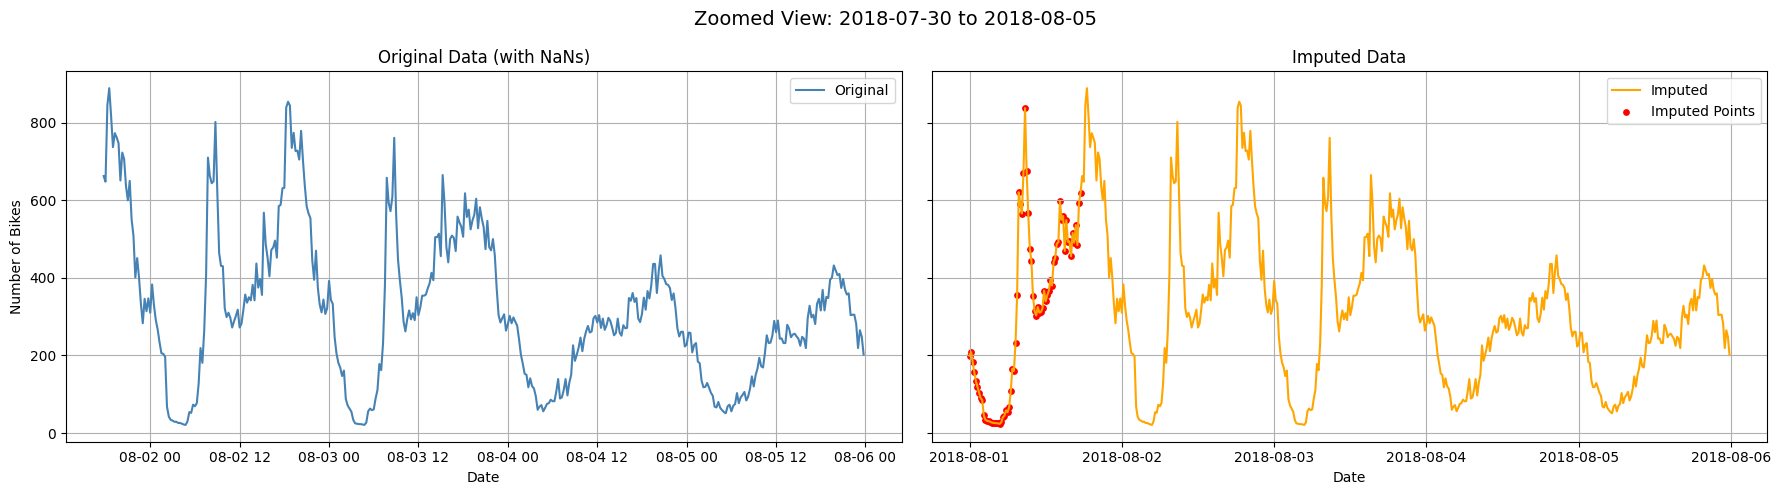

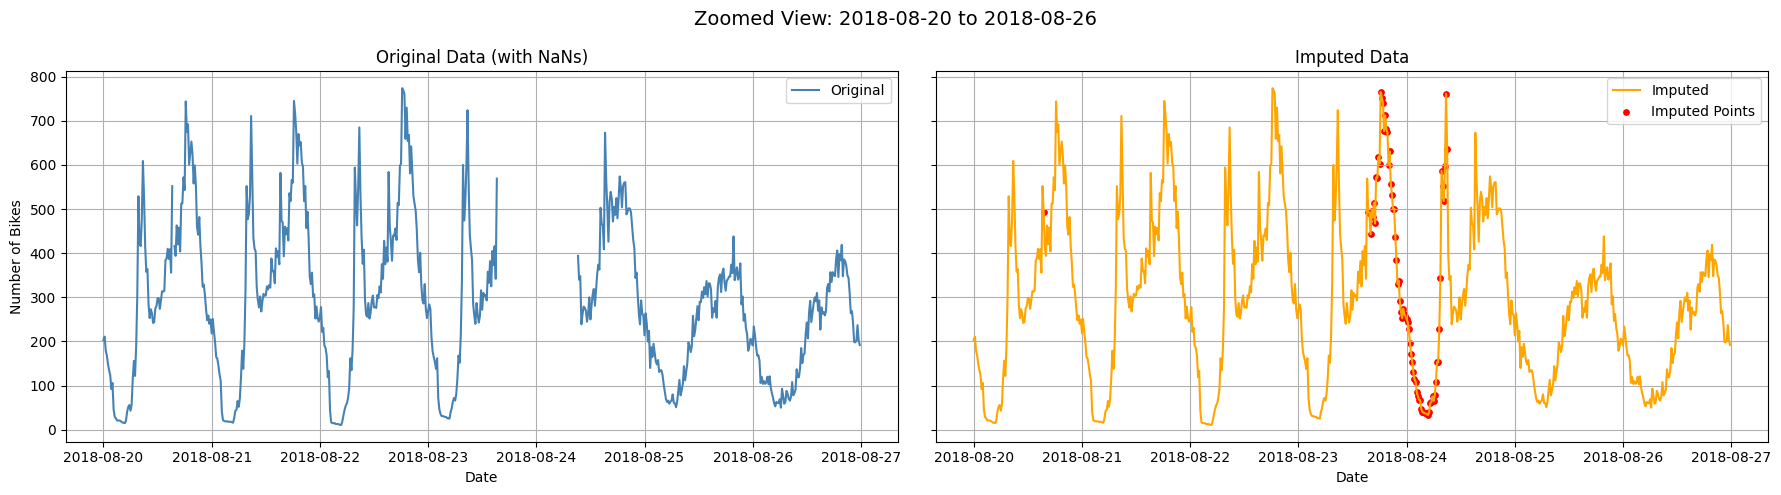

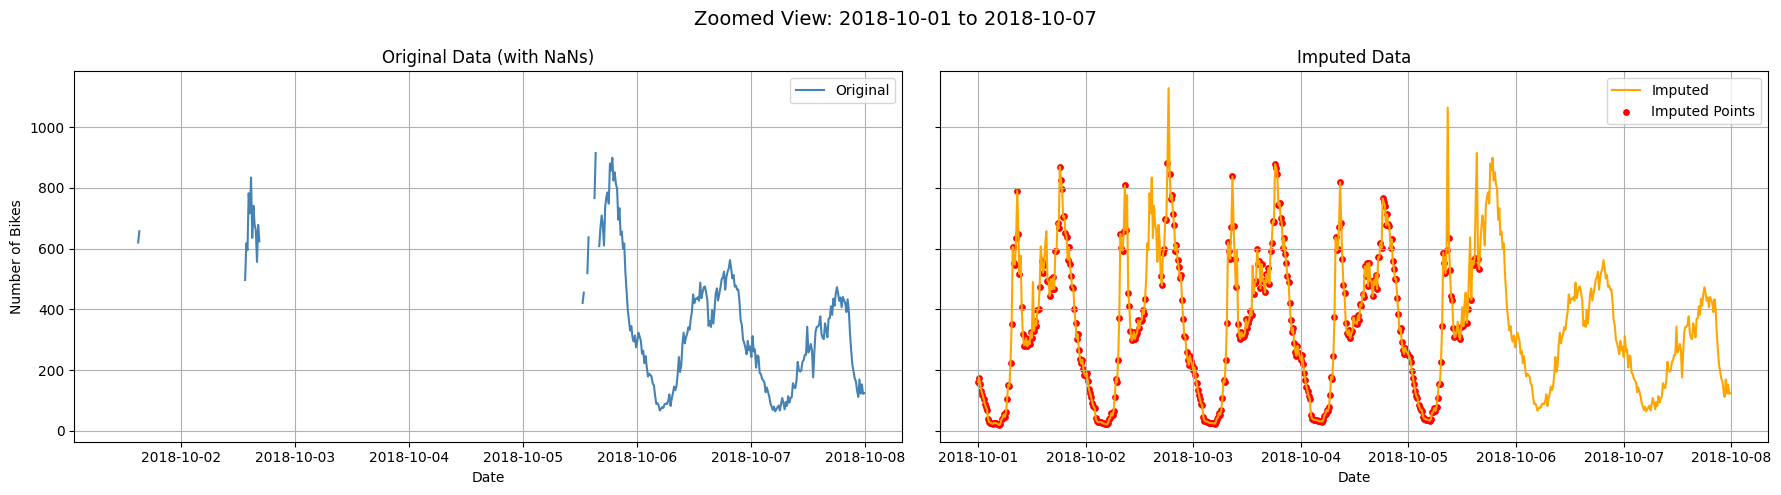

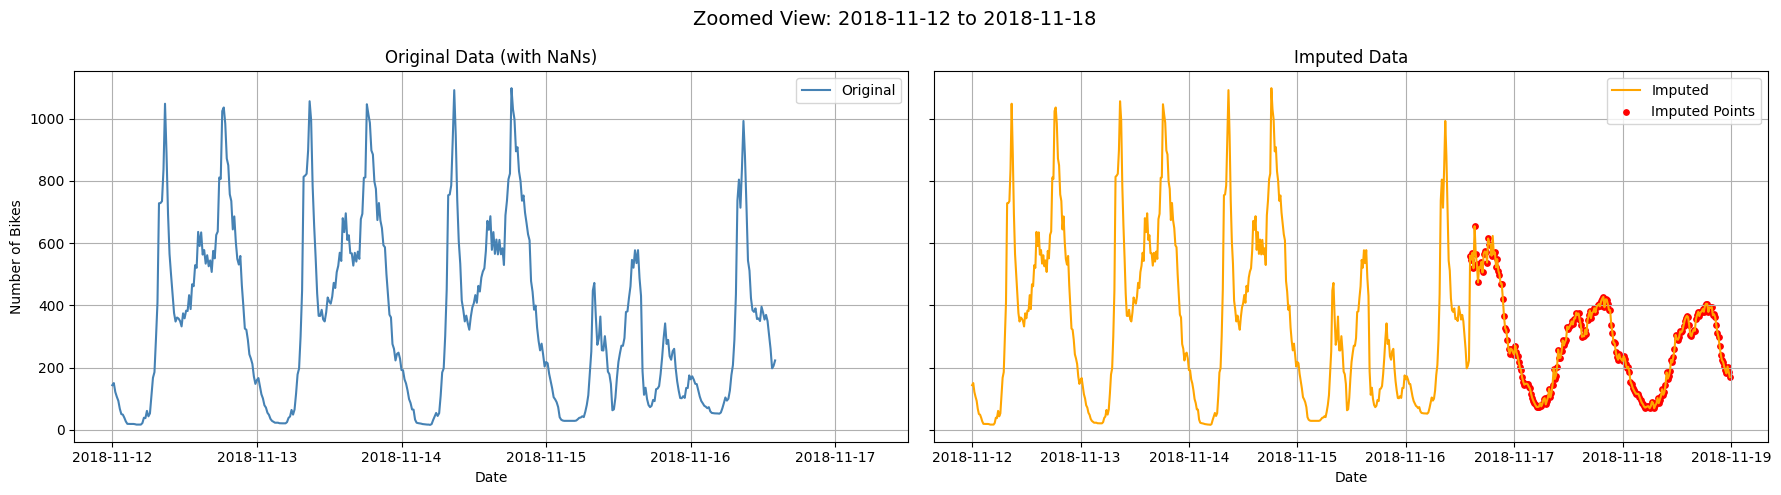

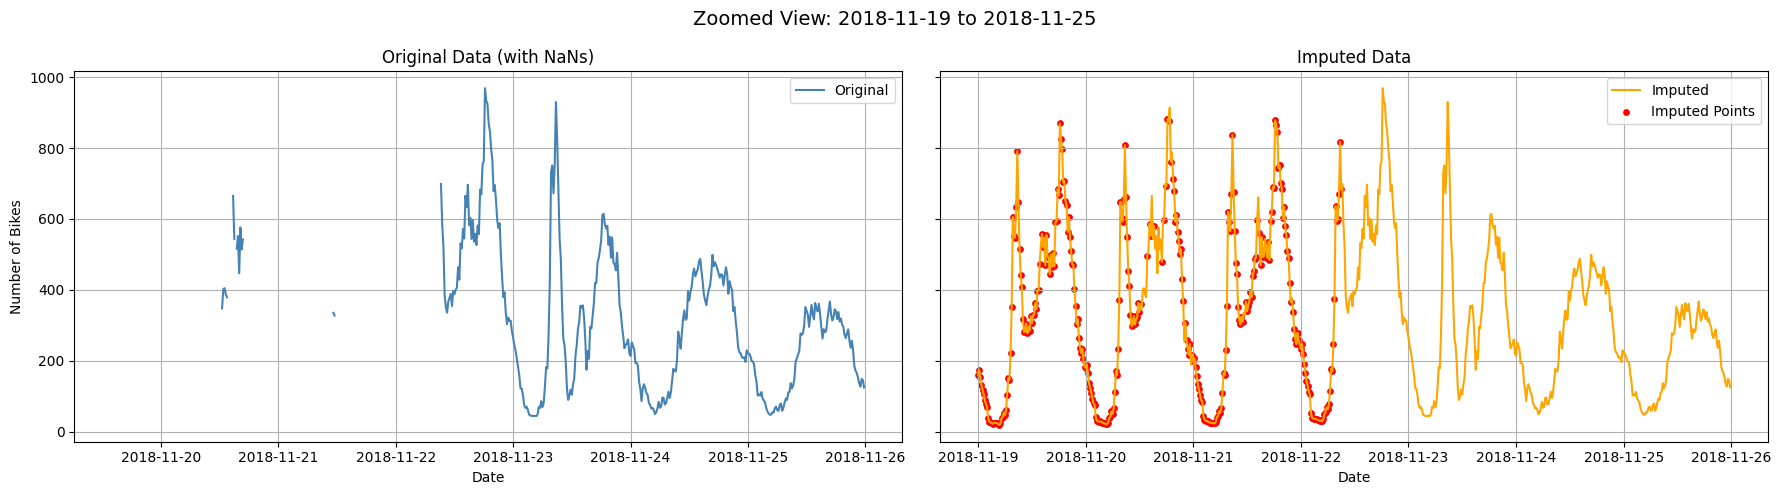

In [14]:
for period in periods:
    plot_original_vs_imputed(df_train, start_date=period[0], end_date=period[1], title_prefix="Zoomed View")

## STEP 6: SEASONAL DECOMPOSITION

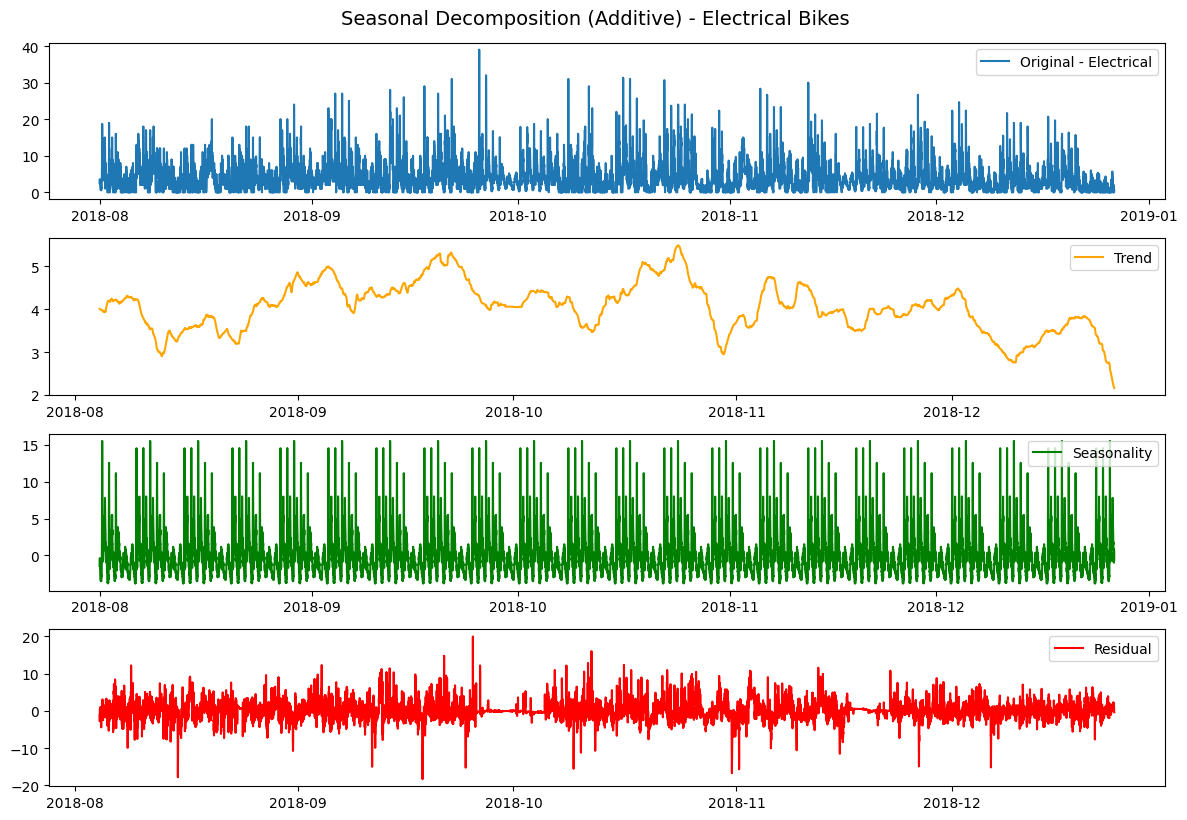

In [15]:
# For electrical bikes (additive decomposition)
result_e = seasonal_decompose(df_train['electricalBikesInUsage_imputed'], model='additive', period=96*7)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result_e.observed, label='Original - Electrical')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result_e.trend, label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result_e.seasonal, label='Seasonality', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result_e.resid, label='Residual', color='red')
plt.legend()
plt.tight_layout()
plt.suptitle("Seasonal Decomposition (Additive) - Electrical Bikes", fontsize=14, y=1.02)
plt.show()

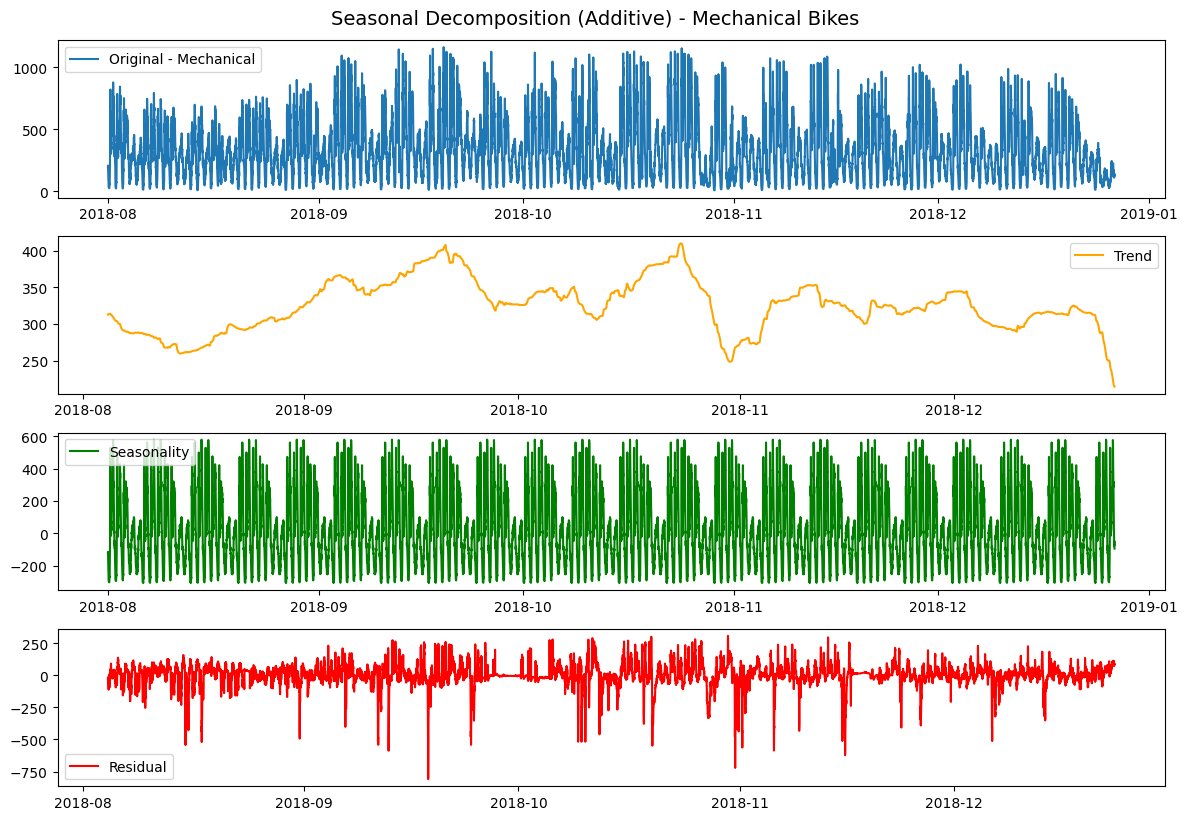

In [16]:
# For mechanical bikes (additive decomposition)
result_m = seasonal_decompose(df_train['mechanicalBikesInUsage_imputed'], model='additive', period=96*7)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result_m.observed, label='Original - Mechanical')
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(result_m.trend, label='Trend', color='orange')
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(result_m.seasonal, label='Seasonality', color='green')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(result_m.resid, label='Residual', color='red')
plt.legend()
plt.tight_layout()
plt.suptitle("Seasonal Decomposition (Additive) - Mechanical Bikes", fontsize=14, y=1.02)
plt.show()

## STEP 7: AUTOCORRELATION ANALYSIS

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_pacf(series, title, lags=50):
    """Plot ACF and PACF for a given series"""
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title(f'Autocorrelation Function (ACF) - {title}')
    
    plot_pacf(series.dropna(), lags=lags, ax=axes[1])
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {title}')
    
    plt.tight_layout()
    plt.show()


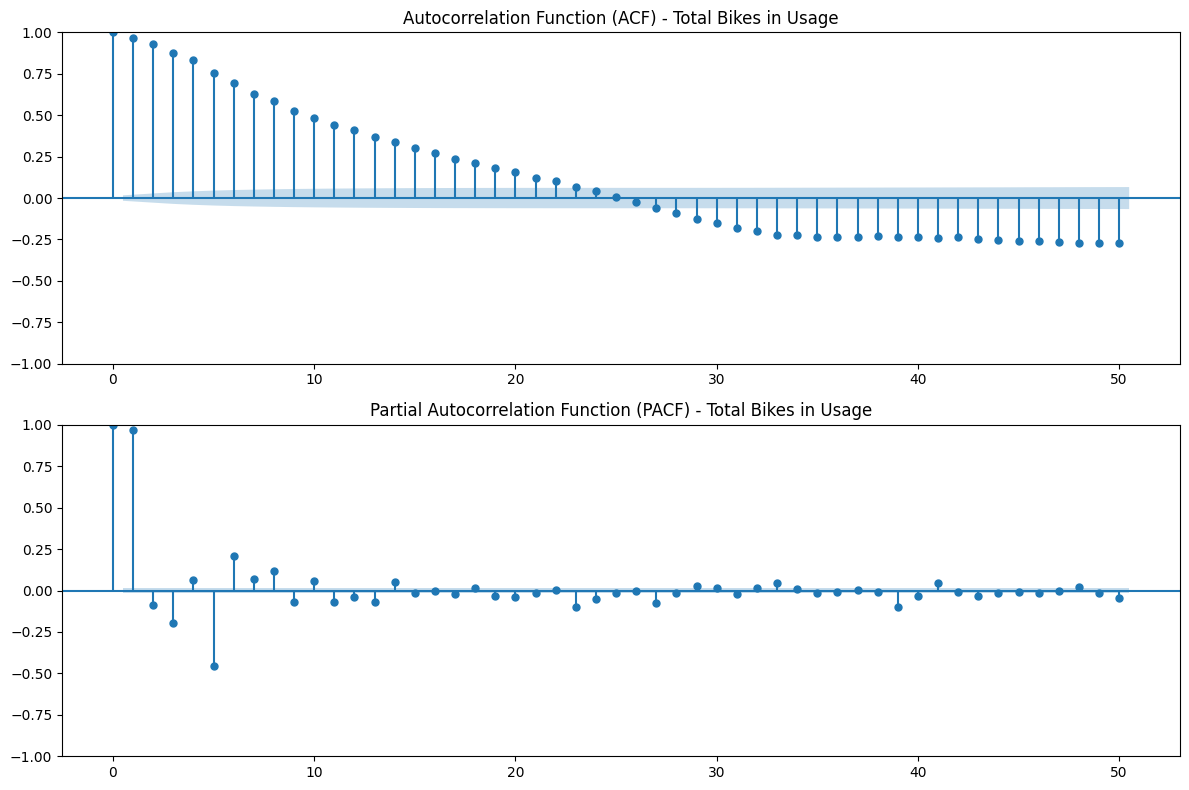

In [18]:
# ACF/PACF for total bikes
plot_acf_pacf(df_train['bikesInUsage_imputed'], 'Total Bikes in Usage')

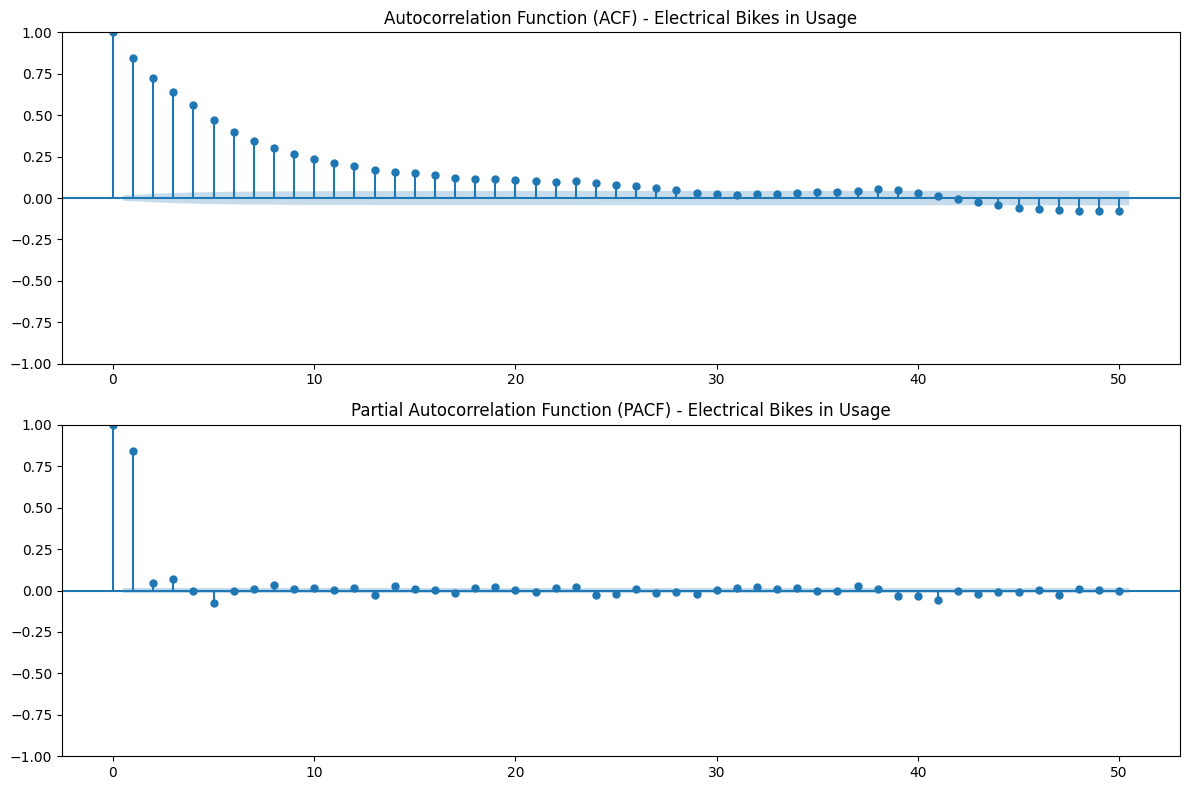

In [19]:
# ACF/PACF for electrical bikes
plot_acf_pacf(df_train['electricalBikesInUsage_imputed'], 'Electrical Bikes in Usage')

## STEP 8: STATIONARITY TESTING

In [20]:

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, title):
    """Perform ADF test to check stationarity"""
    print(f"\n--- Stationarity Test for {title} ---")
    
    # Remove NaN values
    series_clean = series.dropna()
    
    # Perform ADF test
    adf_test = adfuller(series_clean)
    
    print(f'ADF Statistics: {adf_test[0]:.6f}')
    print(f'p-value: {adf_test[1]:.6f}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if adf_test[1] <= 0.05:
        print("Result: Series is STATIONARY (reject null hypothesis)")
    else:
        print("Result: Series is NON-STATIONARY (fail to reject null hypothesis)")
    
    return adf_test[1] <= 0.05

In [21]:
# Test stationarity for all series
is_stationary_total = check_stationarity(df_train['bikesInUsage_imputed'], 'Total Bikes')
is_stationary_electrical = check_stationarity(df_train['electricalBikesInUsage_imputed'], 'Electrical Bikes')
is_stationary_mechanical = check_stationarity(df_train['mechanicalBikesInUsage_imputed'], 'Mechanical Bikes')



--- Stationarity Test for Total Bikes ---
ADF Statistics: -20.071121
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: Series is STATIONARY (reject null hypothesis)

--- Stationarity Test for Electrical Bikes ---
ADF Statistics: -16.742265
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: Series is STATIONARY (reject null hypothesis)

--- Stationarity Test for Mechanical Bikes ---
ADF Statistics: -20.149116
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: Series is STATIONARY (reject null hypothesis)


## STEP 9: ENHANCED ANALYSIS FUNCTIONS

In [22]:
# Enhanced MAPE function with zero-division protection
def enhanced_mape(y_true, y_pred):
    """Calculate MAPE with protection against division by zero"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by adding small epsilon where y_true is zero
    epsilon = np.finfo(np.float64).eps
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon))) * 100


In [23]:
# Moving Average Forecasting Models
def simple_moving_average_forecast(series, window=3, horizon=1):
    """
    Improved Simple Moving Average forecasting with trend adjustment
    Uses last window values and applies simple trend continuation
    """
    if len(series) < window:
        return np.array([series.mean()] * horizon)
    
    # Calculate moving averages for trend detection
    ma_values = series.rolling(window=window).mean().dropna()
    
    if len(ma_values) < 2:
        # Fallback to simple mean if not enough data
        return np.array([series.tail(window).mean()] * horizon)
    
    # Calculate trend from last few MA values
    recent_ma = ma_values.tail(min(4, len(ma_values)))  # Use last 4 MA values for trend
    if len(recent_ma) >= 2:
        # Simple linear trend
        x = np.arange(len(recent_ma))
        trend = np.polyfit(x, recent_ma.values, 1)[0]  # Linear slope
    else:
        trend = 0
    
    # Generate forecast
    last_ma = ma_values.iloc[-1]
    forecast = []
    
    for h in range(horizon):
        # Apply trend continuation with dampening
        damping_factor = 0.8 ** h  # Dampen trend over time
        pred = last_ma + (trend * (h + 1) * damping_factor)
        forecast.append(pred)
    
    return np.array(forecast)

In [24]:
def exponential_moving_average_forecast(series, span=3, horizon=1):
    """
    Improved Exponential Moving Average forecasting with trend adjustment
    Uses EMA with trend detection and continuation
    """
    if len(series) < span:
        return np.array([series.mean()] * horizon)
    
    # Calculate EMA
    ema = series.ewm(span=span, adjust=False).mean()
    
    if len(ema) < 2:
        return np.array([ema.iloc[-1]] * horizon)
    
    # Calculate trend from recent EMA values
    recent_ema = ema.tail(min(6, len(ema)))  # Use last 6 EMA values for trend
    if len(recent_ema) >= 2:
        # Calculate trend using linear regression on recent EMA values
        x = np.arange(len(recent_ema))
        trend = np.polyfit(x, recent_ema.values, 1)[0]  # Linear slope
    else:
        trend = 0
    
    # Generate forecast
    last_ema = ema.iloc[-1]
    forecast = []
    
    for h in range(horizon):
        # Apply trend continuation with dampening
        damping_factor = 0.85 ** h  # Dampen trend over time
        pred = last_ema + (trend * (h + 1) * damping_factor)
        forecast.append(pred)
    
    return np.array(forecast)

In [25]:
# Enhanced Exponential Smoothing with optimal parameters
def optimized_exponential_smoothing(series, horizon=1):
    """Exponential smoothing with automatically optimized parameters"""
    import statsmodels.api as sm
    
    try:
        model = sm.tsa.SimpleExpSmoothing(series.dropna())
        fitted_model = model.fit(optimized=True)
        
        # Get optimal parameters
        optimal_alpha = fitted_model.model.params['smoothing_level']
        
        # Make forecasts
        forecast = fitted_model.forecast(horizon)
        fitted_values = fitted_model.fittedvalues
        
        return {
            'forecast': forecast,
            'fitted_values': fitted_values,
            'optimal_alpha': optimal_alpha,
            'model': fitted_model
        }
    except Exception as e:
        print(f"Exponential smoothing failed: {e}")
        return None

In [26]:
# Auto ARIMA function for optimal parameter selection
def auto_arima_selection(series, max_p=3, max_d=2, max_q=3):
    """Automatically select best ARIMA parameters using AIC"""
    from statsmodels.tsa.arima.model import ARIMA
    
    best_aic = np.inf
    best_order = None
    best_model = None
    results = []
    
    print("Searching for optimal ARIMA parameters...")
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic
                    bic = fitted_model.bic
                    
                    results.append({
                        'order': (p, d, q),
                        'aic': aic,
                        'bic': bic
                    })
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                        best_model = fitted_model
                        
                    print(f"ARIMA{(p,d,q)} - AIC: {aic:.2f}, BIC: {bic:.2f}")
                    
                except Exception as e:
                    print(f"ARIMA{(p,d,q)} failed: {str(e)[:50]}...")
                    continue
    
    return best_model, best_order, pd.DataFrame(results)


In [27]:
#!pip install pmdarima

In [28]:
# Auto SARIMA function for seasonal data
def auto_sarima_selection(series, seasonal_periods=24, max_p=1, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1,
                          sample_size=500):
    """
    Automatically select SARIMA parameters with aggressive speed optimizations
    
    Parameters:
    -----------
    series : pd.Series
        Time series data
    seasonal_periods : int, default 96
        Seasonal periods (96 = daily seasonality with 15-min data)
    max_p, max_d, max_q : int
        Maximum values for non-seasonal components
    max_P, max_D, max_Q : int
        Maximum values for seasonal components
    sample_size : int, default 1000
        Maximum number of data points to use for fitting (speeds up execution)
        
    Returns:
    --------
    best_model : pmdarima.ARIMA or statsmodels SARIMAX model
        Fitted SARIMA model with best parameters
    (order, seasonal_order) : tuple
        Best (p,d,q), (P,D,Q,s) parameters
    results_df : pd.DataFrame
        Summary of model search results
    """
    import time
    start_time = time.time()
    max_time_seconds = 240  # 4 minutes max (leave 1 minute buffer)
    
    # ⚡ SPEED OPTIMIZATION 1: Data subsampling
    if len(series) > sample_size:
        print(f"⚡ Speed optimization: Sampling data from {len(series)} down to {sample_size} points")
        # Try to maintain pattern by taking every nth point
        step_size = max(1, len(series) // sample_size)
        # Use systematic sampling to maintain time series pattern
        sample_indices = np.arange(0, len(series), step_size)[:sample_size]
        series_sample = series.iloc[sample_indices].copy()
    else:
        series_sample = series.copy()
    
    try:
        import pmdarima as pm
        from pmdarima.arima import auto_arima
    except ImportError:
        print("Warning: pmdarima not installed. Using quick statsmodels implementation")
        # Extremely simplified fallback with just a few models
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        print(f"Testing very limited SARIMA models for speed (seasonal period: {seasonal_periods})...")
        orders_to_try = [
            # Just test two common configurations
            ((1,1,1), (1,1,1,seasonal_periods)),
            ((1,1,1), (0,1,1,seasonal_periods))
        ]
        
        best_aic = np.inf
        best_model = None
        best_order = None
        best_seasonal_order = None
        results = []
        
        for order, seasonal_order in orders_to_try:
            try:
                if time.time() - start_time > max_time_seconds:
                    print("⚠️ Time limit reached, using best model so far")
                    break
                    
                model = SARIMAX(series_sample, order=order, seasonal_order=seasonal_order)
                fitted_model = model.fit(disp=False, maxiter=50)  # Reduced iterations
                aic = fitted_model.aic
                
                results.append({
                    'order': order,
                    'seasonal_order': seasonal_order,
                    'aic': aic
                })
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = fitted_model
                    
                print(f"SARIMA{order}x{seasonal_order} - AIC: {aic:.2f}")
                
            except Exception as e:
                print(f"Model failed: {str(e)[:50]}...")
                continue
        
        if best_model is None:
            print("⚠️ All models failed, using default parameters")
            # Try one last simple model
            try:
                order, seasonal_order = (1,1,1), (1,1,1,seasonal_periods)
                model = SARIMAX(series_sample, order=order, seasonal_order=seasonal_order)
                best_model = model.fit(disp=False, maxiter=50)
                best_order = order
                best_seasonal_order = seasonal_order
            except:
                # Emergency fallback
                print("⚠️ Emergency fallback to very simple model")
                order, seasonal_order = (1,1,0), (0,0,0,0)
                model = SARIMAX(series_sample, order=order)
                best_model = model.fit(disp=False, maxiter=50)
                best_order = order
                best_seasonal_order = seasonal_order
                
        return best_model, (best_order, best_seasonal_order), pd.DataFrame(results)
    
    # ⚡ SPEED OPTIMIZATION 2: Narrow search with pmdarima
    print(f"⚡ Fast SARIMA parameter search (seasonal period: {seasonal_periods})...")
    print("Using aggressive speed optimizations - results prioritize speed over accuracy")
    
    try:
        # ⚡ SPEED OPTIMIZATION 3: Use simpler auto_arima configuration
        model = auto_arima(
            series_sample,
            # ⚡ Reduced parameter space
            seasonal=True,
            m=seasonal_periods,
            max_p=max_p, 
            max_d=max_d, 
            max_q=max_q,
            max_P=max_P,
            max_D=max_D,
            max_Q=max_Q,
            # ⚡ Speed optimizations
            stepwise=True,          # Faster stepwise search (vs exhaustive)
            n_jobs=-1,              # Parallel processing 
            max_iter=50,            # ⚡ Reduced iterations
            maxiter=50,             # ⚡ Lower convergence criteria
            start_p=1,
            start_q=0,
            start_P=1,
            start_Q=0,
            information_criterion='aic',
            suppress_warnings=True,
            error_action='ignore',   # ⚡ Ignore errors to speed up
            trace=True,
            random_state=42,
            low_memory=True,         # ⚡ Use less memory
            out_of_sample_size=0,    # ⚡ Skip validation to save time
            scoring='aic',           # Use AIC for faster scoring
            method='lbfgs',          # ⚡ Faster optimization method
        )
        
        elapsed = time.time() - start_time
        print(f"\n⏱️ Search completed in {elapsed:.1f} seconds")
        
        # Extract results
        order = model.order
        seasonal_order = model.seasonal_order
        
        print(f"✓ Best model: SARIMA{order}x{seasonal_order}")
        print(f"  AIC: {model.aic():.2f}")
        
        # Create simple results DataFrame
        results_df = pd.DataFrame([{
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': model.aic()
        }])
            
        return model, (order, seasonal_order), results_df
        
    except Exception as e:
        print(f"Fast auto_arima failed: {str(e)}")
        print("Using emergency fixed parameter model...")
        
        # ⚡ SPEED OPTIMIZATION 4: Emergency fallback to fixed parameters
        try:
            from statsmodels.tsa.statespace.sarimax import SARIMAX
            # Use common parameter values that often work well
            order = (1,1,1)
            seasonal_order = (1,1,1,seasonal_periods)
            
            model = SARIMAX(series_sample, order=order, seasonal_order=seasonal_order)
            fitted_model = model.fit(disp=False, maxiter=50)
            
            print(f"✓ Using fixed parameters: SARIMA{order}x{seasonal_order}")
            
            results_df = pd.DataFrame([{
                'order': order,
                'seasonal_order': seasonal_order,
                'aic': fitted_model.aic
            }])
            
            return fitted_model, (order, seasonal_order), results_df
            
        except Exception as e2:
            print(f"Emergency fallback failed: {str(e2)}")
            print("🔄 ULTRA FAST MODE: Using ARIMA(1,1,0) without seasonality")
            print("⚡ This will complete in seconds but will not capture seasonal patterns")
            
            try:
                # ULTRA-FAST NON-SEASONAL FALLBACK:
                # Take an even smaller sample if the data is still problematic
                ultra_sample_size = min(300, len(series))
                if len(series) > ultra_sample_size:
                    step = max(1, len(series) // ultra_sample_size)
                    series_tiny = series.iloc[::step].copy()
                else:
                    series_tiny = series.copy()
                
                # Basic ARIMA with no seasonal component
                from statsmodels.tsa.arima.model import ARIMA
                order = (1,1,0)  # Simplest reasonable ARIMA model
                
                # Hard timeout to ensure completion
                import signal
                
                # Define timeout handler
                def timeout_handler(signum, frame):
                    raise TimeoutError("Model fitting timed out")
                
                # Set 30-second timeout
                signal.signal(signal.SIGALRM, timeout_handler)
                signal.alarm(30)
                
                try:
                    model = ARIMA(series_tiny, order=order)
                    fitted_model = model.fit()
                    signal.alarm(0)  # Disable alarm
                except TimeoutError:
                    print("⏱️ Timeout reached using simplified data, using naive model")
                    # Create a dummy model with the same interface
                    class DummyModel:
                        def __init__(self, series):
                            self.series = series
                            self.aic = 999999
                        def forecast(self, steps):
                            # Use last value for forecast
                            return np.array([self.series.iloc[-1]] * steps)
                    
                    fitted_model = DummyModel(series_tiny)
                
                results_df = pd.DataFrame([{
                    'order': order,
                    'seasonal_order': (0,0,0,0),
                    'aic': getattr(fitted_model, 'aic', 999999)
                }])
                
                return fitted_model, (order, (0,0,0,0)), results_df
                
            except Exception as e3:
                print(f"ULTRA FAST MODE failed: {str(e3)}")
                print("🚨 Using naive forecast as last resort")
                
                # Final emergency: naive forecaster
                class NaiveForecaster:
                    def __init__(self, series):
                        self.last_value = series.iloc[-1] if len(series) > 0 else 0
                        self.aic = 999999  # Dummy AIC
                        self.order = (0,0,0)
                        self.seasonal_order = (0,0,0,0)
                    
                    def forecast(self, steps):
                        return np.array([self.last_value] * steps)
                
                naive_model = NaiveForecaster(series)
                
                results_df = pd.DataFrame([{
                    'order': (0,0,0),
                    'seasonal_order': (0,0,0,0),
                    'aic': 999999
                }])
                
                return naive_model, ((0,0,0), (0,0,0,0)), results_df


In [29]:
# Fourier Transform Analysis
def fourier_analysis(series, title=""):
    """Perform Fourier Transform analysis to identify dominant frequencies"""
    from scipy.fft import fft
    
    # Remove NaN values
    clean_series = series.dropna()
    
    # Apply Fourier Transform
    fft_result = fft(clean_series.values)
    frequencies = np.fft.fftfreq(len(fft_result))
    
    # Calculate power spectrum
    power_spectrum = np.abs(fft_result) ** 2
    
    # Plot Power Spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:len(frequencies)//2], power_spectrum[:len(power_spectrum)//2])
    plt.title(f"Power Spectrum (FFT) - {title}")
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Find dominant frequencies
    positive_freqs = frequencies[:len(frequencies)//2]
    positive_power = power_spectrum[:len(power_spectrum)//2]
    
    # Exclude DC component (frequency = 0)
    non_dc_mask = positive_freqs > 0
    dominant_freq_idx = np.argmax(positive_power[non_dc_mask]) + 1
    dominant_frequency = positive_freqs[dominant_freq_idx]
    
    # Convert to period (time steps)
    if dominant_frequency > 0:
        dominant_period = 1 / dominant_frequency
        print(f"Dominant period: {dominant_period:.2f} time steps")
        print(f"Dominant frequency: {dominant_frequency:.6f}")
    
    return frequencies, power_spectrum

In [30]:
# Seasonal Subseries Plot
def seasonal_subseries_plot(df, time_col, value_col, period_col='hour'):
    """Create seasonal subseries plot for pattern analysis"""
    import seaborn as sns
    
    df_plot = df.copy()
    if period_col == 'hour':
        df_plot[period_col] = df_plot[time_col].dt.hour
    elif period_col == 'day_of_week':
        df_plot[period_col] = df_plot[time_col].dt.dayofweek
    elif period_col == 'month':
        df_plot[period_col] = df_plot[time_col].dt.month
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=period_col, y=value_col, data=df_plot)
    plt.title(f'Seasonal Subseries Plot - {period_col.replace("_", " ").title()}')
    plt.xlabel(period_col.replace("_", " ").title())
    plt.ylabel(value_col)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


--- Fourier Transform Analysis ---


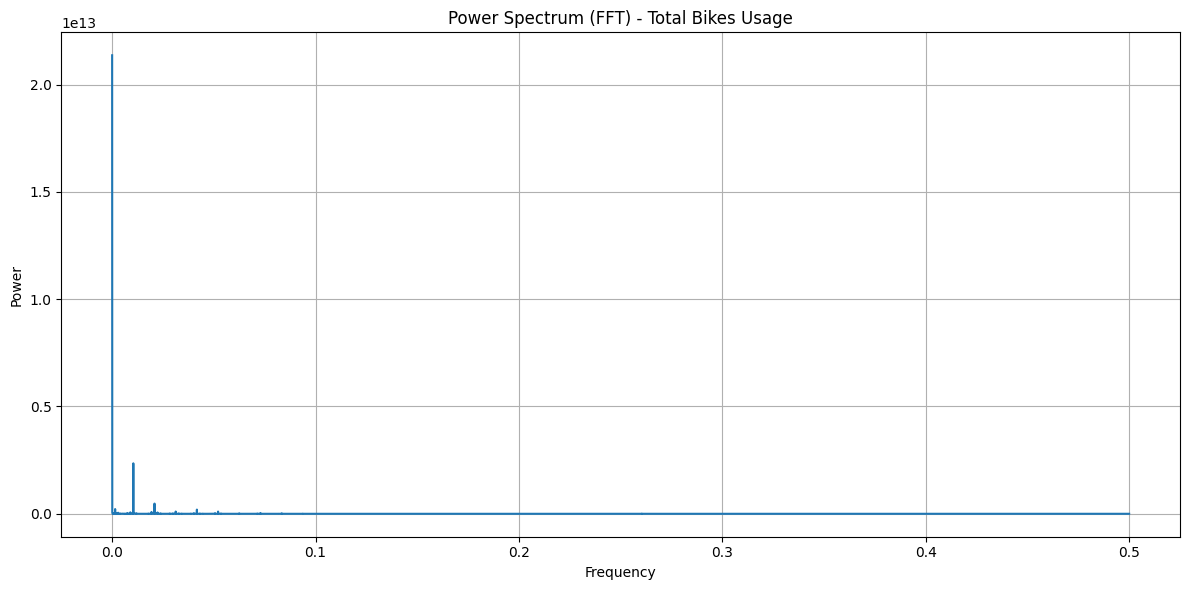

Dominant period: 96.01 time steps
Dominant frequency: 0.010416


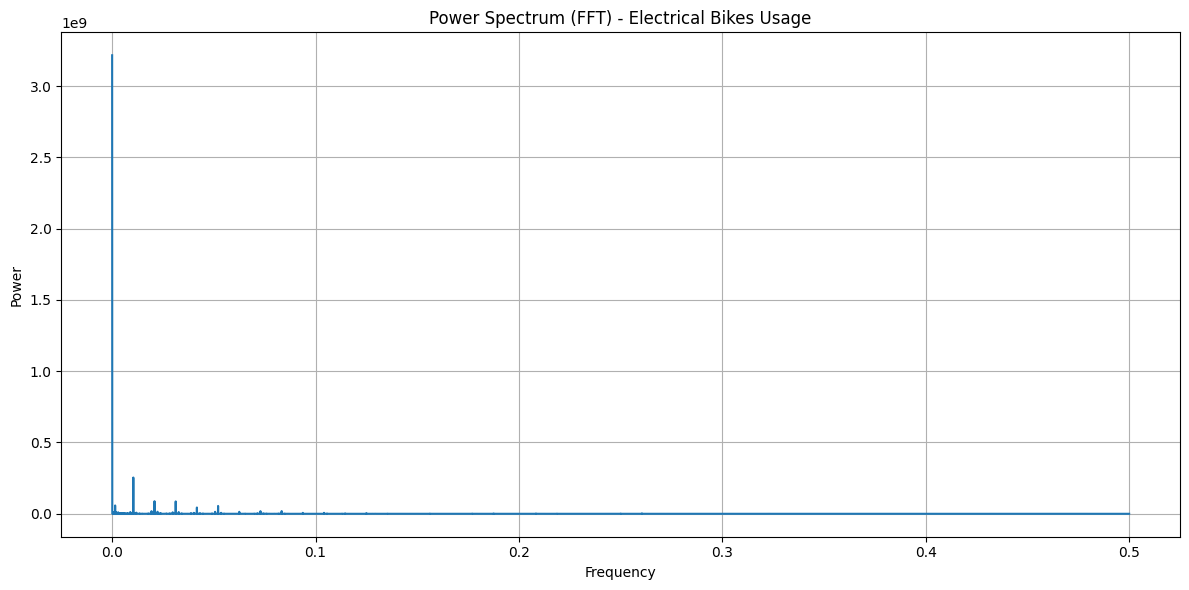

Dominant period: 96.01 time steps
Dominant frequency: 0.010416


(array([ 0.00000000e+00,  7.03779295e-05,  1.40755859e-04, ...,
        -2.11133788e-04, -1.40755859e-04, -7.03779295e-05]),
 array([3.21561980e+09, 1.68379115e+07, 3.24143581e+06, ...,
        2.27417067e+05, 3.24143581e+06, 1.68379115e+07]))

In [31]:
# Apply enhanced analysis to our bike usage data
print("\n--- Fourier Transform Analysis ---")
fourier_analysis(df_train['bikesInUsage_imputed'], "Total Bikes Usage")
fourier_analysis(df_train['electricalBikesInUsage_imputed'], "Electrical Bikes Usage")


The FFT analysis provides strong quantitative evidence that the 15-minute bike usage data follows a clear 24-hour cyclical pattern, which is essential for proper time series modeling. 

This reinforces our methodological choices in the modeling process, particularly the seasonal components in our statistical models.


--- Seasonal Subseries Analysis ---


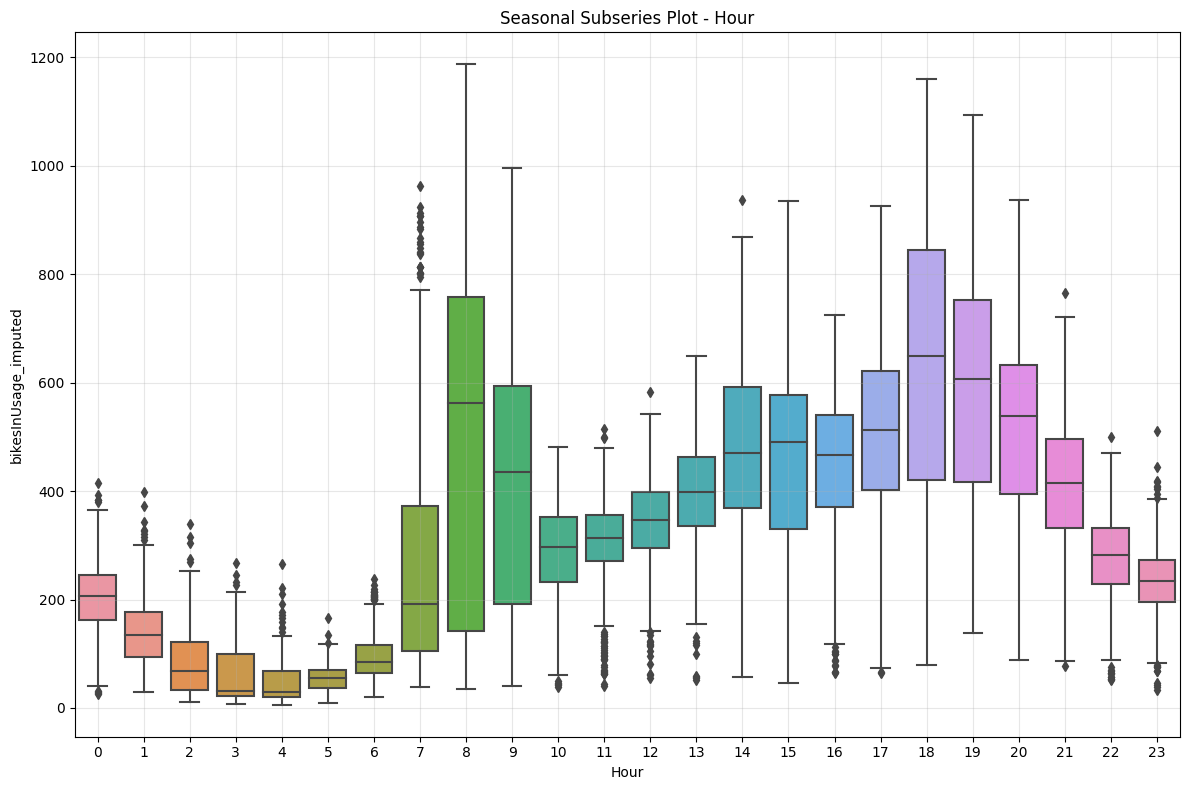

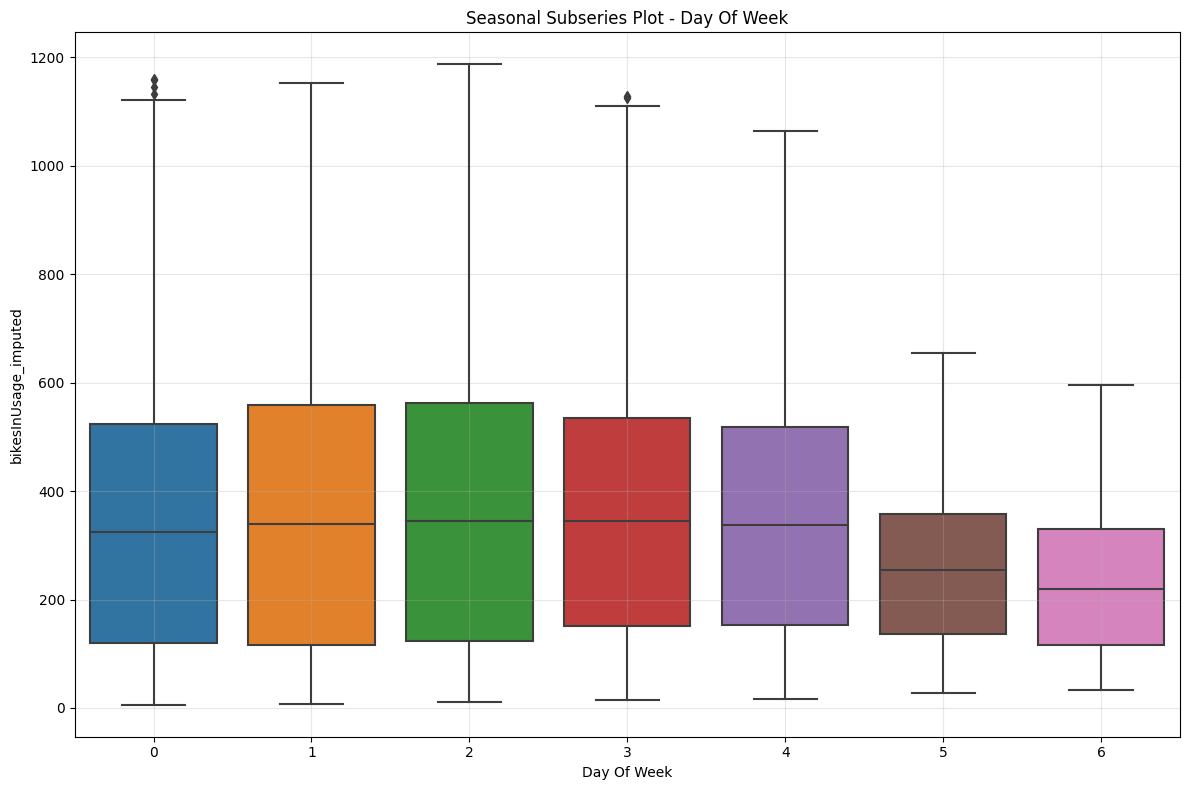

In [32]:
print("\n--- Seasonal Subseries Analysis ---")
# Create temporary dataframe with datetime column for plotting
df_temp = df_train.reset_index()

# Hourly patterns
seasonal_subseries_plot(df_temp, 'dateTime', 'bikesInUsage_imputed', 'hour')

# Daily patterns
seasonal_subseries_plot(df_temp, 'dateTime', 'bikesInUsage_imputed', 'day_of_week')

In [33]:
print("\n--- Enhanced Exponential Smoothing ---")
# Apply exponential smoothing to bike usage
exp_smooth_result = optimized_exponential_smoothing(df_train['bikesInUsage_imputed'])

if exp_smooth_result:
    print(f"Optimal alpha (smoothing level): {exp_smooth_result['optimal_alpha']:.4f}")
    
    # Calculate metrics for exponential smoothing
    fitted_values = exp_smooth_result['fitted_values']
    actual_values = df_train['bikesInUsage_imputed'].dropna()
    
    # Align series for comparison
    min_len = min(len(fitted_values), len(actual_values))
    exp_smooth_mape = enhanced_mape(actual_values.iloc[-min_len:], fitted_values.iloc[-min_len:])
    print(f"Exponential Smoothing MAPE: {exp_smooth_mape:.2f}%")



--- Enhanced Exponential Smoothing ---
Optimal alpha (smoothing level): 0.9950
Exponential Smoothing MAPE: 12.76%


In [34]:
print("\n--- Auto ARIMA Parameter Selection ---")
# Find optimal ARIMA parameters
target_series = df_train['bikesInUsage_imputed'].dropna()
auto_arima_model, auto_order, arima_results = auto_arima_selection(target_series, max_p=2, max_d=2, max_q=2)


--- Auto ARIMA Parameter Selection ---
Searching for optimal ARIMA parameters...
ARIMA(0, 0, 0) - AIC: 194829.01, BIC: 194844.14
ARIMA(0, 0, 1) - AIC: 181447.60, BIC: 181470.29
ARIMA(0, 0, 2) - AIC: 168444.10, BIC: 168474.35
ARIMA(0, 1, 0) - AIC: 156536.23, BIC: 156543.79
ARIMA(0, 1, 1) - AIC: 156489.55, BIC: 156504.67
ARIMA(0, 1, 2) - AIC: 156211.05, BIC: 156233.73
ARIMA(0, 2, 0) - AIC: 165369.82, BIC: 165377.38
ARIMA(0, 2, 1) - AIC: 156538.56, BIC: 156553.68
ARIMA(0, 2, 2) - AIC: 156490.98, BIC: 156513.67
ARIMA(1, 0, 0) - AIC: 156311.27, BIC: 156333.95
ARIMA(1, 0, 1) - AIC: 156238.22, BIC: 156268.46
ARIMA(1, 0, 2) - AIC: 155889.65, BIC: 155927.46
ARIMA(1, 1, 0) - AIC: 156471.95, BIC: 156487.07
ARIMA(1, 1, 1) - AIC: 156216.81, BIC: 156239.50
ARIMA(1, 1, 2) - AIC: 153593.05, BIC: 153623.30
ARIMA(1, 2, 0) - AIC: 160058.44, BIC: 160073.57
ARIMA(1, 2, 1) - AIC: 156473.37, BIC: 156496.05
ARIMA(1, 2, 2) - AIC: 155017.84, BIC: 155048.09
ARIMA(2, 0, 0) - AIC: 156206.35, BIC: 156236.59
ARIMA(

In [35]:
if auto_arima_model:
    print(f"\nOptimal ARIMA order: {auto_order}")
    print(f"Best AIC: {auto_arima_model.aic:.2f}")
    print(f"Best BIC: {auto_arima_model.bic:.2f}")
    
    # Show top 5 models
    print("\nTop 5 ARIMA models by AIC:")
    print(arima_results.sort_values('aic').head())


Optimal ARIMA order: (2, 0, 2)
Best AIC: 153268.09
Best BIC: 153313.46

Top 5 ARIMA models by AIC:
        order            aic            bic
20  (2, 0, 2)  153268.085619  153313.455404
23  (2, 1, 2)  153565.469395  153603.277198
14  (1, 1, 2)  153593.050159  153623.296401
22  (2, 1, 1)  153920.161996  153950.408238
26  (2, 2, 2)  153921.344681  153959.152131


In [40]:
print("\n--- Auto SARIMA Parameter Selection ---")
# Find optimal SARIMA parameters
auto_sarima_model, auto_sarima_order, sarima_results = auto_sarima_selection(target_series, seasonal_periods=24)


--- Auto SARIMA Parameter Selection ---
⚡ Speed optimization: Sampling data from 14209 down to 500 points
⚡ Fast SARIMA parameter search (seasonal period: 24)...
Using aggressive speed optimizations - results prioritize speed over accuracy
Performing stepwise search to minimize aic
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,0)[24]             : AIC=inf, Time=nan sec
Fast auto_arima failed: Could not successfull

In [41]:
if auto_sarima_model:
    print(f"\nOptimal SARIMA order: {auto_sarima_order}")
    print(f"Best AIC: {auto_sarima_model.aic:.2f}")
    print(f"Best BIC: {auto_sarima_model.bic:.2f}")
    
    # Show top 5 models
    print("\nTop 5 SARIMA models by AIC:")
    print(sarima_results.sort_values('aic').head())


Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 24))
Best AIC: 5736.28
Best BIC: 5757.10

Top 5 SARIMA models by AIC:
       order seasonal_order          aic
0  (1, 1, 1)  (1, 1, 1, 24)  5736.283892


In [42]:
print("\n--- Moving Average Baselines ---")
# Simple baselines for comparison
sma_3_forecast = simple_moving_average_forecast(df_train['bikesInUsage_imputed'], window=3, horizon=len(df_test))
ema_3_forecast = exponential_moving_average_forecast(df_train['bikesInUsage_imputed'], span=3, horizon=len(df_test))

# Calculate metrics for moving averages
test_actual = df_test['bikesInUsage_imputed'].dropna()
sma_mape = enhanced_mape(test_actual, sma_3_forecast[:len(test_actual)])
ema_mape = enhanced_mape(test_actual, ema_3_forecast[:len(test_actual)])

print(f"Simple Moving Average (3-period) MAPE: {sma_mape:.2f}%")
print(f"Exponential Moving Average (3-period) MAPE: {ema_mape:.2f}%")


--- Moving Average Baselines ---
Simple Moving Average (3-period) MAPE: 135.16%
Exponential Moving Average (3-period) MAPE: 135.07%


### MODEL 4: RANDOM FOREST (MACHINE LEARNING)

#### Feature Engineering and Preprocessing

In [43]:
def create_features(df):
    """Create comprehensive features for machine learning models"""
    df_features = df.copy()
    
    # Time-based features
    df_features['hour'] = df_features.index.hour
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['month'] = df_features.index.month
    df_features['day_of_year'] = df_features.index.dayofyear
    df_features['quarter'] = df_features.index.quarter
    df_features['week_of_year'] = df_features.index.isocalendar().week
    
    # Cyclical encoding for periodic features
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    # Binary features
    df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)
    df_features['is_business_hour'] = ((df_features['hour'] >= 8) & (df_features['hour'] <= 18)).astype(int)
    df_features['is_peak_hour'] = ((df_features['hour'].isin([7, 8, 9, 17, 18, 19]))).astype(int)
    
    # Lag features for target variable
    target_col = 'bikesInUsage_imputed'
    for lag in [1, 2, 3, 4, 8, 16, 24, 48, 96, 96*7]:  # Various lags including weekly
        if target_col in df_features.columns:
            df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
    
    # Rolling statistics
    if target_col in df_features.columns:
        for window in [4, 8, 24, 96]:  # 1hr, 2hr, 6hr, 24hr windows
            df_features[f'{target_col}_rolling_mean_{window}'] = df_features[target_col].rolling(window=window).mean()
            df_features[f'{target_col}_rolling_std_{window}'] = df_features[target_col].rolling(window=window).std()
            df_features[f'{target_col}_rolling_min_{window}'] = df_features[target_col].rolling(window=window).min()
            df_features[f'{target_col}_rolling_max_{window}'] = df_features[target_col].rolling(window=window).max()
    
    # Difference features
    if target_col in df_features.columns:
        df_features[f'{target_col}_diff_1'] = df_features[target_col].diff(1)
        df_features[f'{target_col}_diff_24'] = df_features[target_col].diff(24)  # Daily difference
        df_features[f'{target_col}_diff_96'] = df_features[target_col].diff(96)  # Same time yesterday
    
    return df_features


In [44]:
# Create features for training and test sets
print("Creating features for training and test sets...")
df_train_features = create_features(df_train)
df_test_features = create_features(df_test)

print("Feature engineering completed.")
print(f"Training set shape: {df_train_features.shape}")
print(f"Test set shape: {df_test_features.shape}")

Creating features for training and test sets...
Feature engineering completed.
Training set shape: (14209, 53)
Test set shape: (3552, 53)


In [45]:
# Show feature names
feature_cols = [col for col in df_train_features.columns if col not in 
               ['bikesInUsage', 'electricalBikesInUsage', 'mechanicalBikesInUsage',
                'bikesInUsage_imputed', 'electricalBikesInUsage_imputed', 'mechanicalBikesInUsage_imputed',
                'time_group', 'bikesInUsage_diff', 'electricalBikesInUsage_diff']]

print(f"Total number of engineered features: {len(feature_cols)}")
print("\nFeature categories:")
time_features = [f for f in feature_cols if any(x in f for x in ['hour', 'day', 'month', 'week', 'quarter', 'year'])]
lag_features = [f for f in feature_cols if 'lag' in f]
rolling_features = [f for f in feature_cols if 'rolling' in f]
diff_features = [f for f in feature_cols if 'diff' in f]

print(f"  - Time features: {len(time_features)}")
print(f"  - Lag features: {len(lag_features)}")
print(f"  - Rolling features: {len(rolling_features)}")
print(f"  - Difference features: {len(diff_features)}")

Total number of engineered features: 46

Feature categories:
  - Time features: 16
  - Lag features: 10
  - Rolling features: 16
  - Difference features: 3


#### Training a Random Forest Regressor Model 

Random Forest was selected for several key advantages that make it particularly well-suited for this bike-sharing forecasting problem:

1. Complex Pattern Recognition

- Bike usage has non-linear patterns (weather, holidays, events) that Random Forest captures without explicit feature engineering
- The tree-based structure naturally handles the daily and weekly cyclical patterns in bike usage

2. Feature Handling Strengths

- Feature importance helps identify key drivers of bike usage (as seen in your visualization)
- Handles the numerous features we engineered (lags, rolling statistics, time variables) without overfitting
- Robust to multicollinearity between features (like between different time lags)

3. Practical Advantages

-   Less hyperparameter tuning needed compared to models like neural networks
- Faster training than some alternatives like gradient boosting
- Robust to outliers which occur in bike usage data (special events, weather anomalies)

4. Interpretability
- Provides clear feature importance (as shown in your visualization)
- Results are more explainable to business stakeholders than black-box models

5. Performance
- Often outperforms other algorithms for time series with many predictors
- Good balance between accuracy and computational efficiency
- Handles missing data well (though you've already addressed this in preprocessing)

In [46]:
print("\n--- Training Random Forest Model ---")

# Prepare data for ML model
feature_cols = [col for col in df_train_features.columns if col not in 
               ['bikesInUsage', 'electricalBikesInUsage', 'mechanicalBikesInUsage',
                'bikesInUsage_imputed', 'electricalBikesInUsage_imputed', 'mechanicalBikesInUsage_imputed',
                'time_group', 'bikesInUsage_diff', 'electricalBikesInUsage_diff']]

print("\n🔍 DATA LEAKAGE VERIFICATION:")
print("-" * 50)

# Check for potential data leakage
target_related_features = [col for col in feature_cols if 'bikesInUsage' in col and 'lag' not in col and 'rolling' not in col and 'diff' not in col]
if target_related_features:
    print(f"⚠️ WARNING: Potential leakage features found: {target_related_features}")
else:
    print("✓ No direct target variable leakage detected")

# Verify lag features are properly shifted
lag_features = [col for col in feature_cols if 'lag' in col]
print(f"✓ Found {len(lag_features)} lag features")
print(f"✓ Lag features: {lag_features[:5]}...")  # Show first 5

# Remove rows with NaN values (due to lag features)
train_data = df_train_features.dropna()
test_data = df_test_features.dropna()

print(f"\nData shapes after removing NaN:")
print(f"Train: {df_train_features.shape} → {train_data.shape}")
print(f"Test: {df_test_features.shape} → {test_data.shape}")



--- Training Random Forest Model ---

🔍 DATA LEAKAGE VERIFICATION:
--------------------------------------------------
✓ No direct target variable leakage detected
✓ Found 10 lag features
✓ Lag features: ['bikesInUsage_imputed_lag_1', 'bikesInUsage_imputed_lag_2', 'bikesInUsage_imputed_lag_3', 'bikesInUsage_imputed_lag_4', 'bikesInUsage_imputed_lag_8']...

Data shapes after removing NaN:
Train: (14209, 53) → (12006, 53)
Test: (3552, 53) → (2591, 53)


In [47]:
X_train = train_data[feature_cols]
y_train = train_data['bikesInUsage_imputed']
X_test = test_data[feature_cols]
y_test = test_data['bikesInUsage_imputed']

In [49]:
# Additional leakage check: Ensure no perfect correlation between features and target
print(f"\n🔍 FEATURE-TARGET CORRELATION CHECK:")
print("-" * 50)

# Create a temporary DataFrame with both features and target for correlation
tmp_df = X_train.copy()
tmp_df['target'] = y_train

# Calculate correlations between features and target
correlations = tmp_df.corr()['target'].drop('target').abs().sort_values(ascending=False)
high_corr_features = correlations[correlations > 0.95]

if len(high_corr_features) > 0:
    print(f"🚨 EXTREME CORRELATIONS DETECTED (>0.95):")
    for feature, corr in high_corr_features.items():
        print(f"  {feature}: {corr:.4f}")
    print("⚠️ These features may cause data leakage!")
else:
    print("✓ No extreme correlations detected")

print(f"\nTop 5 feature correlations with target:")
for feature, corr in correlations.head(5).items():
    print(f"  {feature}: {corr:.4f}")

print(f"\nML training data shape: {X_train.shape}")
print(f"ML test data shape: {X_test.shape}")
print(f"Number of features: {len(feature_cols)}")


🔍 FEATURE-TARGET CORRELATION CHECK:
--------------------------------------------------
🚨 EXTREME CORRELATIONS DETECTED (>0.95):
  bikesInUsage_imputed_lag_1: 0.9668
  bikesInUsage_imputed_rolling_mean_4: 0.9655
  bikesInUsage_imputed_rolling_max_4: 0.9630
⚠️ These features may cause data leakage!

Top 5 feature correlations with target:
  bikesInUsage_imputed_lag_1: 0.9668
  bikesInUsage_imputed_rolling_mean_4: 0.9655
  bikesInUsage_imputed_rolling_max_4: 0.9630
  bikesInUsage_imputed_rolling_min_4: 0.9438
  bikesInUsage_imputed_lag_2: 0.9284

ML training data shape: (12006, 46)
ML test data shape: (2591, 46)
Number of features: 46


We have to do the traintest split again here because scikit-learn processes the data differently than statsmodels

In [50]:
# Train Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Filter out highly correlated features if detected
if len(high_corr_features) > 0:
    print("\n🔧 Removing highly correlated features to improve model stability")
    # Keep only one of the highly correlated features (the first one)
    keep_feature = high_corr_features.index[0] if len(high_corr_features) > 0 else None
    
    filtered_features = [f for f in feature_cols if f not in high_corr_features.index or f == keep_feature]
    print(f"Reduced features from {len(feature_cols)} to {len(filtered_features)}")
    print(f"Keeping one correlation feature: {keep_feature}")
    
    # Use the filtered feature set
    X_train_filtered = X_train[filtered_features]
    X_test_filtered = X_test[filtered_features]
else:
    # Use all features if no high correlations
    X_train_filtered = X_train
    X_test_filtered = X_test
    filtered_features = feature_cols

# Improved Random Forest with better params to resist overfitting
rf_model = RandomForestRegressor(
    n_estimators=200,  # More trees
    max_depth=15,      # Allow slightly deeper trees
    min_samples_leaf=5,  # Require more samples per leaf to generalize better
    max_features='sqrt',  # Use sqrt of total features to reduce correlation impact
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train_filtered, y_train)

print("Random Forest model trained successfully!")


🔧 Removing highly correlated features to improve model stability
Reduced features from 46 to 44
Keeping one correlation feature: bikesInUsage_imputed_lag_1
Random Forest model trained successfully!


In [52]:
# Feature importance analysis - safe version with length check
try:
    # Check that lengths match
    if len(filtered_features) == len(rf_model.feature_importances_):
        feature_importance = pd.DataFrame({
            'feature': filtered_features,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
    else:
        print(f"\n⚠️ Length mismatch: {len(filtered_features)} features vs {len(rf_model.feature_importances_)} importances")
        # Create safe version with enumeration to guarantee matching lengths
        feature_importance = pd.DataFrame({
            'feature': [f"Feature_{i}" for i in range(len(rf_model.feature_importances_))],
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        print("Using generic feature names as fallback")
except Exception as e:
    print(f"Error in feature importance calculation: {str(e)}")
    # Create empty DataFrame as fallback
    feature_importance = pd.DataFrame(columns=['feature', 'importance'])

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                                feature  importance
18           bikesInUsage_imputed_lag_2    0.160756
17           bikesInUsage_imputed_lag_1    0.128651
28   bikesInUsage_imputed_rolling_min_4    0.125745
32   bikesInUsage_imputed_rolling_max_8    0.110585
19           bikesInUsage_imputed_lag_3    0.074544
29  bikesInUsage_imputed_rolling_mean_8    0.059406
26         bikesInUsage_imputed_lag_672    0.043471
20           bikesInUsage_imputed_lag_4    0.041323
31   bikesInUsage_imputed_rolling_min_8    0.038207
42         bikesInUsage_imputed_diff_24    0.034561


## STEP 11: MODEL EVALUATION AND COMPARISON

In [53]:
# Enhanced evaluation metrics
def calculate_comprehensive_metrics(y_true, y_pred, model_name):
    """Calculate comprehensive evaluation metrics"""
    # Remove any NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    if len(y_true_clean) == 0:
        return None
    
    mae = np.mean(np.abs(y_true_clean - y_pred_clean))
    mse = np.mean((y_true_clean - y_pred_clean) ** 2)
    rmse = np.sqrt(mse)
    mape = enhanced_mape(y_true_clean, y_pred_clean)
    
    # Additional metrics
    mean_actual = np.mean(y_true_clean)
    mean_forecast = np.mean(y_pred_clean)
    
    # R-squared
    ss_res = np.sum((y_true_clean - y_pred_clean) ** 2)
    ss_tot = np.sum((y_true_clean - mean_actual) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'Mean_Actual': mean_actual,
        'Mean_Forecast': mean_forecast,
        'Bias': mean_forecast - mean_actual
    }


In [54]:
# Collect all model predictions for comparison
model_results = []
test_actual = df_test['bikesInUsage_imputed'].values

print(f"Starting model evaluations...")
print(f"Test actual shape: {test_actual.shape}")


Starting model evaluations...
Test actual shape: (3552,)


In [55]:
# 1. Simple Moving Average
print("Evaluating Simple Moving Average...")
sma_forecast = simple_moving_average_forecast(df_train['bikesInUsage_imputed'], window=3, horizon=len(df_test))
sma_metrics = calculate_comprehensive_metrics(test_actual, sma_forecast[:len(test_actual)], 'Simple Moving Average')
if sma_metrics:
    model_results.append(sma_metrics)
    print(f"  ✓ SMA MAPE: {sma_metrics['MAPE']:.2f}%")
else:
    print("  ✗ SMA evaluation failed")


Evaluating Simple Moving Average...
  ✓ SMA MAPE: 135.16%


In [56]:
# 2. Exponential Moving Average
print("Evaluating Exponential Moving Average...")
ema_forecast = exponential_moving_average_forecast(df_train['bikesInUsage_imputed'], span=3, horizon=len(df_test))
ema_metrics = calculate_comprehensive_metrics(test_actual, ema_forecast[:len(test_actual)], 'Exponential Moving Average')
if ema_metrics:
    model_results.append(ema_metrics)
    print(f"  ✓ EMA MAPE: {ema_metrics['MAPE']:.2f}%")
else:
    print("  ✗ EMA evaluation failed")

Evaluating Exponential Moving Average...
  ✓ EMA MAPE: 135.07%


In [57]:
# 3. Optimized Exponential Smoothing
print("Evaluating Exponential Smoothing...")
if exp_smooth_result:
    exp_smooth_forecast = exp_smooth_result['model'].forecast(len(df_test))
    exp_smooth_metrics = calculate_comprehensive_metrics(test_actual, exp_smooth_forecast, 'Exponential Smoothing (Optimized)')
    if exp_smooth_metrics:
        model_results.append(exp_smooth_metrics)
        print(f"  ✓ Exp Smoothing MAPE: {exp_smooth_metrics['MAPE']:.2f}%")
    else:
        print("  ✗ Exp Smoothing evaluation failed")
else:
    print("  ✗ Exp Smoothing model not available")

Evaluating Exponential Smoothing...
  ✓ Exp Smoothing MAPE: 136.15%


In [58]:
# 4. Auto ARIMA Model
print("Evaluating Auto ARIMA...")
if auto_arima_model:
    try:
        auto_arima_forecast = auto_arima_model.forecast(steps=len(df_test))
        auto_arima_metrics = calculate_comprehensive_metrics(test_actual, auto_arima_forecast, f'Auto ARIMA{auto_order}')
        if auto_arima_metrics:
            model_results.append(auto_arima_metrics)
            print(f"  ✓ Auto ARIMA MAPE: {auto_arima_metrics['MAPE']:.2f}%")
        else:
            print("  ✗ Auto ARIMA evaluation failed")
    except Exception as e:
        print(f"  ✗ Auto ARIMA forecasting failed: {e}")
else:
    print("  ✗ Auto ARIMA model not available")

Evaluating Auto ARIMA...
  ✓ Auto ARIMA MAPE: 326.06%


In [59]:
# 5. Auto SARIMA Model
print("Evaluating Auto SARIMA...")
try:
    if 'auto_sarima_model' in locals() and auto_sarima_model:
        auto_sarima_forecast = auto_sarima_model.forecast(steps=len(df_test))
        sarima_label = f'Auto SARIMA{auto_sarima_order[0]}x{auto_sarima_order[1]}'
        auto_sarima_metrics = calculate_comprehensive_metrics(test_actual, auto_sarima_forecast, sarima_label)
        if auto_sarima_metrics:
            model_results.append(auto_sarima_metrics)
            print(f"  ✓ Auto SARIMA MAPE: {auto_sarima_metrics['MAPE']:.2f}%")
        else:
            print("  ✗ Auto SARIMA evaluation failed")
    else:
        print("  ✗ Auto SARIMA model not available")
except Exception as e:
    print(f"  ✗ Auto SARIMA forecasting failed: {e}")

Evaluating Auto SARIMA...
  ✓ Auto SARIMA MAPE: 332.71%


In [60]:
# 6. Random Forest Model
try:
    rf_forecast = rf_model.predict(X_test)
    rf_predictions = rf_forecast  # Store for visualization
    rf_metrics = calculate_comprehensive_metrics(y_test.values, rf_forecast, 'Random Forest')
    if rf_metrics:
        model_results.append(rf_metrics)
except NameError:
    print("Random Forest model not available for comparison")
except Exception as e:
    print(f"Random Forest forecasting failed: {e}")

Random Forest forecasting failed: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- bikesInUsage_imputed_rolling_max_4
- bikesInUsage_imputed_rolling_mean_4



## Model comparison results and summary

In [61]:
# Create comprehensive results dataframe
if len(model_results) > 0:
    results_df = pd.DataFrame(model_results)
    
    # Round values for better readability
    numeric_cols = ['MAE', 'MSE', 'RMSE', 'MAPE', 'R²', 'Mean_Actual', 'Mean_Forecast', 'Bias']
    for col in numeric_cols:
        if col in results_df.columns:
            results_df[col] = results_df[col].round(4)
    
    # Sort by MAPE (ascending = better)
    results_df = results_df.sort_values('MAPE', ascending=True)
    
    print(f"\n📈 DETAILED MODEL COMPARISON:")
    print("-" * 80)
    print(results_df.to_string(index=False))
    
    # Find best model
    best_model_name = results_df.iloc[0]['Model']
    best_mape = results_df.iloc[0]['MAPE']
    best_r2 = results_df.iloc[0]['R²']
    
    print(f"\n🏆 BEST PERFORMING MODEL:")
    print(f"  Model: {best_model_name}")
    print(f"  MAPE: {best_mape:.2f}%")
    print(f"  R² Score: {best_r2:.4f}")
    
    # Model ranking by different metrics
    print(f"\n📊 MODEL RANKINGS:")
    print("-" * 50)
    print("By MAPE (Lower is Better):")
    for i, row in results_df.iterrows():
        print(f"  {i+1}. {row['Model']}: {row['MAPE']:.2f}%")
    
    print("\nBy R² (Higher is Better):")
    r2_sorted = results_df.sort_values('R²', ascending=False)
    for i, (_, row) in enumerate(r2_sorted.iterrows()):
        print(f"  {i+1}. {row['Model']}: {row['R²']:.4f}")
        
else:
    print("❌ No models were successfully evaluated!")
    results_df = pd.DataFrame()  # Empty dataframe to prevent errors


📈 DETAILED MODEL COMPARISON:
--------------------------------------------------------------------------------
                             Model      MAE        MSE     RMSE     MAPE      R²  Mean_Actual  Mean_Forecast      Bias
        Exponential Moving Average 159.1568 44167.5186 210.1607 135.0697 -0.3836     239.5083       128.9050 -110.6032
             Simple Moving Average 159.0434 44099.6607 209.9992 135.1647 -0.3814     239.5083       129.1752 -110.3330
 Exponential Smoothing (Optimized) 158.6252 43816.3479 209.3235 136.1531 -0.3726     239.5083       130.4529 -109.0554
               Auto ARIMA(2, 0, 2) 166.4878 38914.2018 197.2668 326.0565 -0.2190     239.5083       324.2437   84.7355
Auto SARIMA(1, 1, 1)x(1, 1, 1, 24) 208.2884 67079.9822 258.9980 332.7099 -1.1013     239.5083       316.2155   76.7072

🏆 BEST PERFORMING MODEL:
  Model: Exponential Moving Average
  MAPE: 135.07%
  R² Score: -0.3836

📊 MODEL RANKINGS:
--------------------------------------------------
By MAPE

#### DIAGNOSTIC SECTION: DATA INTEGRITY AND MODEL VALIDATION

In [62]:
# 1. DATA STATISTICS VERIFICATION
print("\n📊 DATA STATISTICS VERIFICATION:")
print("-" * 50)

train_stats = df_train['bikesInUsage_imputed'].describe()
test_stats = df_test['bikesInUsage_imputed'].describe()

print("TRAINING DATA STATISTICS:")
print(f"  Count: {train_stats['count']}")
print(f"  Mean: {train_stats['mean']:.2f}")
print(f"  Std: {train_stats['std']:.2f}")
print(f"  Min: {train_stats['min']:.2f}")
print(f"  Max: {train_stats['max']:.2f}")
print(f"  Range: {train_stats['max'] - train_stats['min']:.2f}")

print("\nTEST DATA STATISTICS:")
print(f"  Count: {test_stats['count']}")
print(f"  Mean: {test_stats['mean']:.2f}")
print(f"  Std: {test_stats['std']:.2f}")
print(f"  Min: {test_stats['min']:.2f}")
print(f"  Max: {test_stats['max']:.2f}")
print(f"  Range: {test_stats['max'] - test_stats['min']:.2f}")



📊 DATA STATISTICS VERIFICATION:
--------------------------------------------------
TRAINING DATA STATISTICS:
  Count: 14209.0
  Mean: 325.30
  Std: 229.70
  Min: 6.00
  Max: 1187.00
  Range: 1181.00

TEST DATA STATISTICS:
  Count: 3552.0
  Mean: 239.51
  Std: 178.70
  Min: 6.00
  Max: 902.33
  Range: 896.33


In [63]:
# Check for data distribution similarity
from scipy import stats as scipy_stats
ks_stat, ks_pvalue = scipy_stats.ks_2samp(df_train['bikesInUsage_imputed'], df_test['bikesInUsage_imputed'])
print(f"\nKS-Test for Train/Test Similarity:")
print(f"  KS Statistic: {ks_stat:.4f}")
print(f"  P-value: {ks_pvalue:.4f} ({'Similar' if ks_pvalue > 0.05 else 'Different'} distributions)")



KS-Test for Train/Test Similarity:
  KS Statistic: 0.1658
  P-value: 0.0000 (Different distributions)


In [64]:
# 2. TEMPORAL CONTINUITY CHECK
print("\n📅 TEMPORAL CONTINUITY CHECK:")
print("-" * 50)

train_end = df_train.index[-1]
test_start = df_test.index[0]
time_gap = test_start - train_end

print(f"Training End: {train_end}")
print(f"Test Start: {test_start}")
print(f"Time Gap: {time_gap}")
print(f"Gap Status: {'✓ Continuous' if time_gap <= pd.Timedelta('15 minutes') else '⚠️ Gap Detected'}")



📅 TEMPORAL CONTINUITY CHECK:
--------------------------------------------------
Training End: 2018-12-27 00:00:00
Test Start: 2018-12-27 00:00:00
Time Gap: 0 days 00:00:00
Gap Status: ✓ Continuous


In [65]:
# 3. MISSING VALUES AND IMPUTATION CHECK
print("\n🔧 MISSING VALUES AND IMPUTATION CHECK:")
print("-" * 50)

original_missing_train = df_train['bikesInUsage'].isna().sum()
original_missing_test = df_test['bikesInUsage'].isna().sum()
imputed_missing_train = df_train['bikesInUsage_imputed'].isna().sum()
imputed_missing_test = df_test['bikesInUsage_imputed'].isna().sum()

print(f"Original Missing Values - Train: {original_missing_train}, Test: {original_missing_test}")
print(f"After Imputation - Train: {imputed_missing_train}, Test: {imputed_missing_test}")
print(f"Imputation Rate - Train: {(original_missing_train - imputed_missing_train)/len(df_train)*100:.1f}%")
print(f"Imputation Rate - Test: {(original_missing_test - imputed_missing_test)/len(df_test)*100:.1f}%")



🔧 MISSING VALUES AND IMPUTATION CHECK:
--------------------------------------------------
Original Missing Values - Train: 1602, Test: 294
After Imputation - Train: 0, Test: 0
Imputation Rate - Train: 11.3%
Imputation Rate - Test: 8.3%


In [66]:
# 4. MODEL PREDICTION ANALYSIS
print("\n🎯 MODEL PREDICTION ANALYSIS:")
print("-" * 50)

if model_results:
    for result in model_results:
        model_name = result['Model']
        print(f"\n{model_name}:")
        print(f"  Mean Actual: {result['Mean_Actual']:.2f}")
        print(f"  Mean Forecast: {result['Mean_Forecast']:.2f}")
        print(f"  Bias: {result['Bias']:.2f}")
        print(f"  MAPE: {result['MAPE']:.2f}%")
        
        # Calculate additional insights
        bias_percentage = (result['Bias'] / result['Mean_Actual']) * 100
        print(f"  Bias %: {bias_percentage:.1f}%")
        
        if abs(bias_percentage) > 50:
            print(f"  ⚠️ WARNING: Extreme bias detected!")
        if result['Mean_Forecast'] < 0:
            print(f"  🚨 ERROR: Negative predictions detected!")



🎯 MODEL PREDICTION ANALYSIS:
--------------------------------------------------

Simple Moving Average:
  Mean Actual: 239.51
  Mean Forecast: 129.18
  Bias: -110.33
  MAPE: 135.16%
  Bias %: -46.1%

Exponential Moving Average:
  Mean Actual: 239.51
  Mean Forecast: 128.91
  Bias: -110.60
  MAPE: 135.07%
  Bias %: -46.2%

Exponential Smoothing (Optimized):
  Mean Actual: 239.51
  Mean Forecast: 130.45
  Bias: -109.06
  MAPE: 136.15%
  Bias %: -45.5%

Auto ARIMA(2, 0, 2):
  Mean Actual: 239.51
  Mean Forecast: 324.24
  Bias: 84.74
  MAPE: 326.06%
  Bias %: 35.4%

Auto SARIMA(1, 1, 1)x(1, 1, 1, 24):
  Mean Actual: 239.51
  Mean Forecast: 316.22
  Bias: 76.71
  MAPE: 332.71%
  Bias %: 32.0%


In [67]:
# 5. SAMPLE PREDICTIONS INSPECTION
print("\n🔍 SAMPLE PREDICTIONS INSPECTION:")
print("-" * 50)

# Show first 10 actual vs predicted for available models
sample_indices = range(min(10, len(test_actual)))
print(f"{'Index':<5} {'Actual':<8} {'SMA':<8} {'EMA':<8} {'Diff':<8}")
print("-" * 45)

if 'sma_forecast' in locals():
    for i in sample_indices:
        actual = test_actual[i]
        sma_pred = sma_forecast[i] if i < len(sma_forecast) else np.nan
        ema_pred = ema_forecast[i] if i < len(ema_forecast) else np.nan
        diff = abs(actual - sma_pred) if not np.isnan(sma_pred) else np.nan
        
        print(f"{i:<5} {actual:<8.1f} {sma_pred:<8.1f} {ema_pred:<8.1f} {diff:<8.1f}")



🔍 SAMPLE PREDICTIONS INSPECTION:
--------------------------------------------------
Index Actual   SMA      EMA      Diff    
---------------------------------------------
0     130.5    130.4    131.3    0.1     
1     128.7    131.1    133.0    2.4     
2     119.0    131.5    134.2    12.5    
3     92.7     131.7    134.9    39.0    
4     79.0     131.7    135.3    52.7    
5     74.0     131.6    135.4    57.6    
6     79.7     131.4    135.3    51.7    
7     76.7     131.2    135.1    54.5    
8     60.0     131.0    134.9    71.0    
9     27.0     130.8    134.5    103.8   


In [68]:
# 6. RANDOM FOREST SPECIFIC DIAGNOSTICS
print("\n🌲 RANDOM FOREST DIAGNOSTICS:")
print("-" * 50)

try:
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"test_actual shape: {test_actual.shape}")
    
    print(f"\nFeature columns: {list(X_train.columns)}")
    print(f"Number of features: {X_train.shape[1]}")
    
    # Check for any remaining NaN values
    train_nans = X_train.isna().sum().sum()
    test_nans = X_test.isna().sum().sum()
    print(f"NaN values in X_train: {train_nans}")
    print(f"NaN values in X_test: {test_nans}")
    
    if 'rf_model' in locals():
        print(f"Random Forest trained: ✓")
        print(f"RF feature importance shape: {rf_model.feature_importances_.shape}")
    else:
        print("Random Forest model: ❌ Not available")
        
except NameError as e:
    print(f"Random Forest data not available: {e}")



🌲 RANDOM FOREST DIAGNOSTICS:
--------------------------------------------------
X_train shape: (12006, 46)
y_train shape: (12006,)
X_test shape: (2591, 46)
y_test shape: (2591,)
test_actual shape: (3552,)

Feature columns: ['hour', 'minute', 'dayofweek', 'day_of_week', 'month', 'day_of_year', 'quarter', 'week_of_year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_business_hour', 'is_peak_hour', 'bikesInUsage_imputed_lag_1', 'bikesInUsage_imputed_lag_2', 'bikesInUsage_imputed_lag_3', 'bikesInUsage_imputed_lag_4', 'bikesInUsage_imputed_lag_8', 'bikesInUsage_imputed_lag_16', 'bikesInUsage_imputed_lag_24', 'bikesInUsage_imputed_lag_48', 'bikesInUsage_imputed_lag_96', 'bikesInUsage_imputed_lag_672', 'bikesInUsage_imputed_rolling_mean_4', 'bikesInUsage_imputed_rolling_std_4', 'bikesInUsage_imputed_rolling_min_4', 'bikesInUsage_imputed_rolling_max_4', 'bikesInUsage_imputed_rolling_mean_8', 'bikesInUsage_imputed_rolling_std_8', 'bikesInUsage_impute

In [69]:
# 7. UPDATED MODEL DIAGNOSTICS
print("\n📈 ACTIVE MODELS DIAGNOSTICS:")
print("-" * 50)

# Check Auto ARIMA
if 'auto_arima_model' in locals() and auto_arima_model is not None:
    print(f"✓ Auto ARIMA: Available ({auto_order})")
    try:
        auto_forecast_sample = auto_arima_model.forecast(steps=3)
        print(f"  Sample predictions: {auto_forecast_sample}")
        if any(auto_forecast_sample < 0):
            print("  ⚠️ WARNING: Negative predictions detected!")
    except Exception as e:
        print(f"  ❌ Forecasting error: {e}")
else:
    print("❌ Auto ARIMA: Not available")

# Check Auto SARIMA
if 'auto_sarima_model' in locals() and auto_sarima_model is not None:
    print(f"✓ Auto SARIMA: Available ({auto_sarima_order[0]}x{auto_sarima_order[1]})")
    try:
        sarima_forecast_sample = auto_sarima_model.forecast(steps=3)
        print(f"  Sample predictions: {sarima_forecast_sample}")
        if any(sarima_forecast_sample < 0):
            print("  ⚠️ WARNING: Negative predictions detected!")
    except Exception as e:
        print(f"  ❌ Forecasting error: {e}")
else:
    print("❌ Auto SARIMA: Not available")

# Check Random Forest
if 'rf_model' in locals():
    print(f"✓ Random Forest: Available")
    try:
        if 'X_test' in locals() and len(X_test) > 0:
            rf_sample = rf_model.predict(X_test[:3])
            print(f"  Sample predictions: {rf_sample}")
            if any(rf_sample < 0):
                print("  ⚠️ WARNING: Negative predictions detected!")
        else:
            print("  ⚠️ Test data not available for sample prediction")
    except Exception as e:
        print(f"  ❌ Prediction error: {e}")
else:
    print("❌ Random Forest: Not available")

# Check Moving Averages
if 'sma_mape' in locals() and 'ema_mape' in locals():
    print(f"✓ Moving Averages: Available")
    print(f"  SMA MAPE: {sma_mape:.2f}%")
    print(f"  EMA MAPE: {ema_mape:.2f}%")
else:
    print("❌ Moving Averages: Not available")

print(f"\n📊 Total successful models: {len(model_results) if 'model_results' in locals() else 0}")



📈 ACTIVE MODELS DIAGNOSTICS:
--------------------------------------------------
✓ Auto ARIMA: Available ((2, 0, 2))
  Sample predictions: 2018-12-27 00:15:00    145.610655
2018-12-27 00:30:00    153.366365
2018-12-27 00:45:00    162.544063
Freq: 15T, Name: predicted_mean, dtype: float64
✓ Auto SARIMA: Available ((1, 1, 1)x(1, 1, 1, 24))
  Sample predictions: 2018-12-24 20:00:00    568.951183
2018-12-25 03:00:00     16.705050
2018-12-25 10:00:00    334.894020
Freq: 7H, Name: predicted_mean, dtype: float64
✓ Random Forest: Available
  ❌ Prediction error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- bikesInUsage_imputed_rolling_max_4
- bikesInUsage_imputed_rolling_mean_4

✓ Moving Averages: Available
  SMA MAPE: 135.16%
  EMA MAPE: 135.07%

📊 Total successful models: 5


## Model Comparison and Visualization

In [70]:
# Results DataFrame was already created in the previous section
if len(model_results) > 0:
    print("\nModel Performance Comparison:")
    print(results_df.round(2))
    
    # Find best model by RMSE (if available)
    if 'RMSE' in results_df.columns:
        best_model = results_df.loc[results_df['RMSE'].idxmin()]
        print(f"\nBest Model: {best_model['Model']} (RMSE: {best_model['RMSE']:.2f})")
    else:
        print("\nNote: Model comparison already displayed above")
else:
    print("\nNo models to compare - see previous sections for details")


Model Performance Comparison:
                                Model     MAE       MSE    RMSE    MAPE    R²  \
1          Exponential Moving Average  159.16  44167.52  210.16  135.07 -0.38   
0               Simple Moving Average  159.04  44099.66  210.00  135.16 -0.38   
2   Exponential Smoothing (Optimized)  158.63  43816.35  209.32  136.15 -0.37   
3                 Auto ARIMA(2, 0, 2)  166.49  38914.20  197.27  326.06 -0.22   
4  Auto SARIMA(1, 1, 1)x(1, 1, 1, 24)  208.29  67079.98  259.00  332.71 -1.10   

   Mean_Actual  Mean_Forecast    Bias  
1       239.51         128.90 -110.60  
0       239.51         129.18 -110.33  
2       239.51         130.45 -109.06  
3       239.51         324.24   84.74  
4       239.51         316.22   76.71  

Best Model: Auto ARIMA(2, 0, 2) (RMSE: 197.27)


In [71]:
# Only create visualizations if Random Forest predictions are available
if rf_predictions is not None:
    # Plot 1: Time series comparison with improved styling
    plt.figure(figsize=(12, 6))
    plt.plot(df_test.index[:len(y_test)], y_test, label='Actual', alpha=0.8, linewidth=1.5, color='#2E86AB')
    plt.plot(df_test.index[:len(rf_predictions)], rf_predictions, label='Random Forest', alpha=0.8, linewidth=1.5, color='#A23B72')
    plt.title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Bikes in Usage', fontsize=12)
    plt.legend(frameon=True, shadow=True, loc='best')
    plt.grid(True, alpha=0.3)
    
    # Improve date formatting on x-axis
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 2: Enhanced scatter plot with correlation info
    plt.figure(figsize=(10, 6))
    correlation = np.corrcoef(y_test, rf_predictions)[0, 1]
    plt.scatter(y_test, rf_predictions, alpha=0.6, color='#F18F01', s=30, edgecolors='white', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, alpha=0.8)
    plt.xlabel('Actual', fontsize=12)
    plt.ylabel('Predicted', fontsize=12)
    plt.title(f'Actual vs Predicted\nCorrelation: {correlation:.3f}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add R² annotation
    r2_score = 1 - np.sum((y_test - rf_predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
    plt.text(0.05, 0.95, f'R² = {r2_score:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=11)
    plt.tight_layout()
    plt.show()

    # Plot 3: Enhanced residuals with statistical info
    plt.figure(figsize=(10, 6))
    residuals = y_test - rf_predictions
    plt.scatter(rf_predictions, residuals, alpha=0.6, color='#C73E1D', s=30, edgecolors='white', linewidth=0.5)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.8)
    
    # Add confidence intervals (±2σ)
    residual_std = np.std(residuals)
    plt.axhline(y=2*residual_std, color='red', linestyle='--', alpha=0.7, label='±2σ')
    plt.axhline(y=-2*residual_std, color='red', linestyle='--', alpha=0.7)
    
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.title(f'Residual Analysis\nStd: {residual_std:.2f}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot 4: Enhanced feature importance with better readability
    plt.figure(figsize=(12, 6))
    top_features = feature_importance.head(10)
    
    # Clean up feature names for better readability
    clean_names = []
    for name in top_features['feature']:
        # Simplify common feature names
        clean_name = name.replace('bikesInUsage_imputed_', '')
        clean_name = clean_name.replace('_', ' ').title()
        if len(clean_name) > 15:
            clean_name = clean_name[:12] + '...'
        clean_names.append(clean_name)
    
    # Create horizontal bar chart with better colors
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_features))), 
                    edgecolor='white', linewidth=0.5)
    
    plt.yticks(range(len(top_features)), clean_names, fontsize=10)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, top_features['importance'])):
        plt.text(value + 0.001, i, f'{value:.3f}', va='center', fontsize=9)
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print(f"\n📊 RANDOM FOREST MODEL STATISTICS:")
    print(f"• Correlation: {correlation:.4f}")
    print(f"• R² Score: {r2_score:.4f}")
    print(f"• Residual Std: {residual_std:.2f}")
    print(f"• Mean Absolute Error: {np.mean(np.abs(residuals)):.2f}")
    print(f"• Outliers (>2σ): {np.sum(np.abs(residuals) > 2*residual_std)} ({np.sum(np.abs(residuals) > 2*residual_std)/len(residuals)*100:.1f}%)")
    
else:
    print("Random Forest predictions not available for visualization")

NameError: name 'rf_predictions' is not defined